In [1]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import pytensor as pyt
import xarray as xr
import random
import nutpie
import numpyro
import blackjax

az.style.use("arviz-darkgrid")
pyt.config.exception_verbosity = 'low'

In [2]:
first_day_value = 1
first_trial_value = 1

In [3]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [4]:
df = pd.read_csv('modeldata.csv')

In [5]:
df

fish       stage  day  distance       yds  trial
0      fish3    Baseline    1  2.454436 -0.593089      1
1      fish3    Baseline    1  6.767645  3.303538      2
2      fish3    Baseline    1  5.604250  1.553468      3
3      fish3    Baseline    1  9.601868  2.407542      4
4      fish3    Baseline    1  2.919447  0.098092      5
...      ...         ...  ...       ...       ...    ...
1382  fish10  ReRotation   15  2.893217  0.123611      2
1383  fish10  ReRotation   15  2.099540  0.199964      3
1384  fish10  ReRotation   15  2.254680  0.111023      4
1385  fish10  ReRotation   15  5.730466  4.275042      5
1386  fish10  ReRotation   15  3.900021  2.917670      6

[1387 rows x 6 columns]

## Define model

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [5]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['yds_first'] - merged_data['yds_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()

# Priors for τ_μμ
merged_data['halfway_yds'] = (merged_data['yds_first'] + merged_data['yds_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_yds']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['yds'] < df_avg['halfway_yds']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()*2
σ_τμ = df_avg_below_halfway['day'].std()*2

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['yds'].mean()
σ_μμ_inf = mean_last_day['yds'].std()

In [7]:
# print(f'{μ_Aμμ=}')
# print(f'{σ_Aμμ=}')

# print(f'{mode_τμ=}')
# print(f'{σ_τμ=}')

# print(f'{μ_μμ_inf=}')
# print(f'{σ_μμ_inf=}')

μ_Aμμ=0.43480587417444666
σ_Aμμ=2.1082369800260343
mode_τμ=3.75
σ_τμ=2.1756225162774294
μ_μμ_inf=0.40577716150617443
σ_μμ_inf=1.383168036872369


#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [6]:
# Priors for Aσμ
mode_Aσμ = merged_data['difference'].std()
std_Aσμ = merged_data['difference'].std()

sh_Aσμ,ra_Aσμ = gamma_shra_from_modesd(mode_Aσμ, std_Aσμ)

# Priors for σ_μ∞
mode_σμ_inf = mean_last_day['yds'].std()
std_σμ_inf = mean_last_day['yds'].std()

sh_σμ_inf,ra_σμ_inf = gamma_shra_from_modesd(mode_σμ_inf, std_σμ_inf)

In [10]:
# print(f'{mode_Aσμ=}')
# print(f'{std_Aσμ=}')

# # print(f'{μ_τμ=}')
# print(f'{σ_τμ=}')



mode_Aσμ=2.1082369800260343
std_Aσμ=2.1082369800260343
σ_τμ=2.1756225162774294


#### σ priors
This is the prior for the σ which controls the likelihood.

In [7]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'std'}).reset_index()
df_std.rename(columns={'yds': 'std_yds'}, inplace=True)

std_mean = np.mean(df_std['std_yds'])
std_std = np.std(df_std['std_yds'])

mode_σ = std_mean
σ_σ = std_std

sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

In [12]:
# print(f'{mode_σ=}')
# print(f'{σ_σ=}')

# print(f'{sh_σ=}')
# print(f'{ra_σ=}')

mode_σ=2.1750377215921626
σ_σ=1.295219427734266
sh_σ=4.602722873290658
ra_σ=1.6563955822584113


### PyMC model code
#### Make codings for fish and stage

In [8]:
fish_list = [3, 7, 9, 10]
days = {'Baseline': 25, 'Rotation': 16, 'Washout': 10, 'ReRotation': 15, 'Washout 2': 10}
stage_list = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'Washout 2']

fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}
# Extracting just the numeric part of the 'fish' column
df['fish_id'] = df['fish'].str.extract('(\d+)').astype(int)  # \d+ matches one or more digits
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish_id'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value
num_data = df.shape[0]


In [9]:
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

with pm.Model(coords=coords) as m_yds:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ
    A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Normal('μ_μ_inf', mu=μ_μμ_inf, sigma=σ_μμ_inf, dims=('fish', 'stages'))

    A_σμ = pm.Gamma('A_σμ', alpha=sh_Aσμ, beta=ra_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.Gamma('σ_μ_inf', alpha=sh_σμ_inf, beta=ra_σμ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ
    μ_μ = pm.Deterministic('μ_μ', A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_], dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')


     ### level 2: Priors for the likelihood
    μ_std = pm.Normal('μ_std', mu=0, sigma=1, dims='data')
    μ = pm.Deterministic('μ', μ_μ + μ_std*σ_μ)    
    # μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')

    
    ### data likelihood level 1
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
    y = pm.Normal('y', mu=μ, sigma=σ, observed=df['yds'], dims='data')



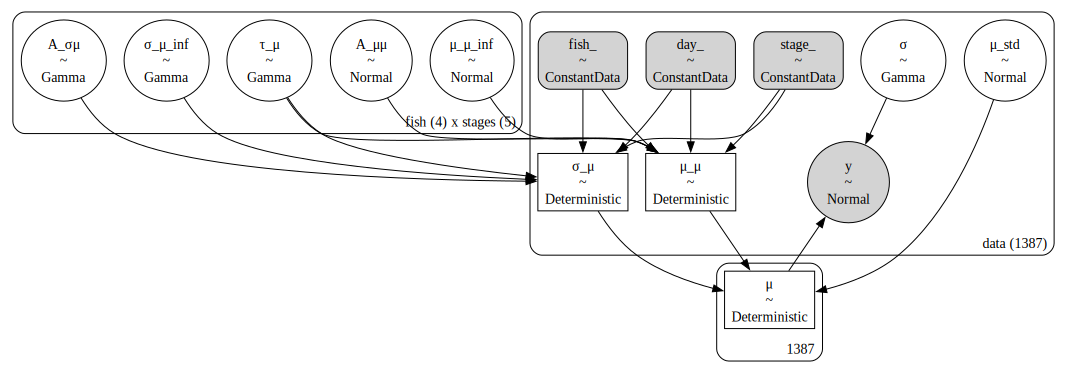

In [11]:
# pm.model_to_graphviz(m_yds)

# Priors
## Sample prior predictive

In [10]:
id_yds = pm.sample_prior_predictive(samples=200, model=m_yds)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data


id_yds

Sampling: [A_μμ, A_σμ, y, μ_std, μ_μ_inf, σ, σ_μ_inf, τ_μ]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [11]:
start_day = -25
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [12]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 10)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_34428\3239911825.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


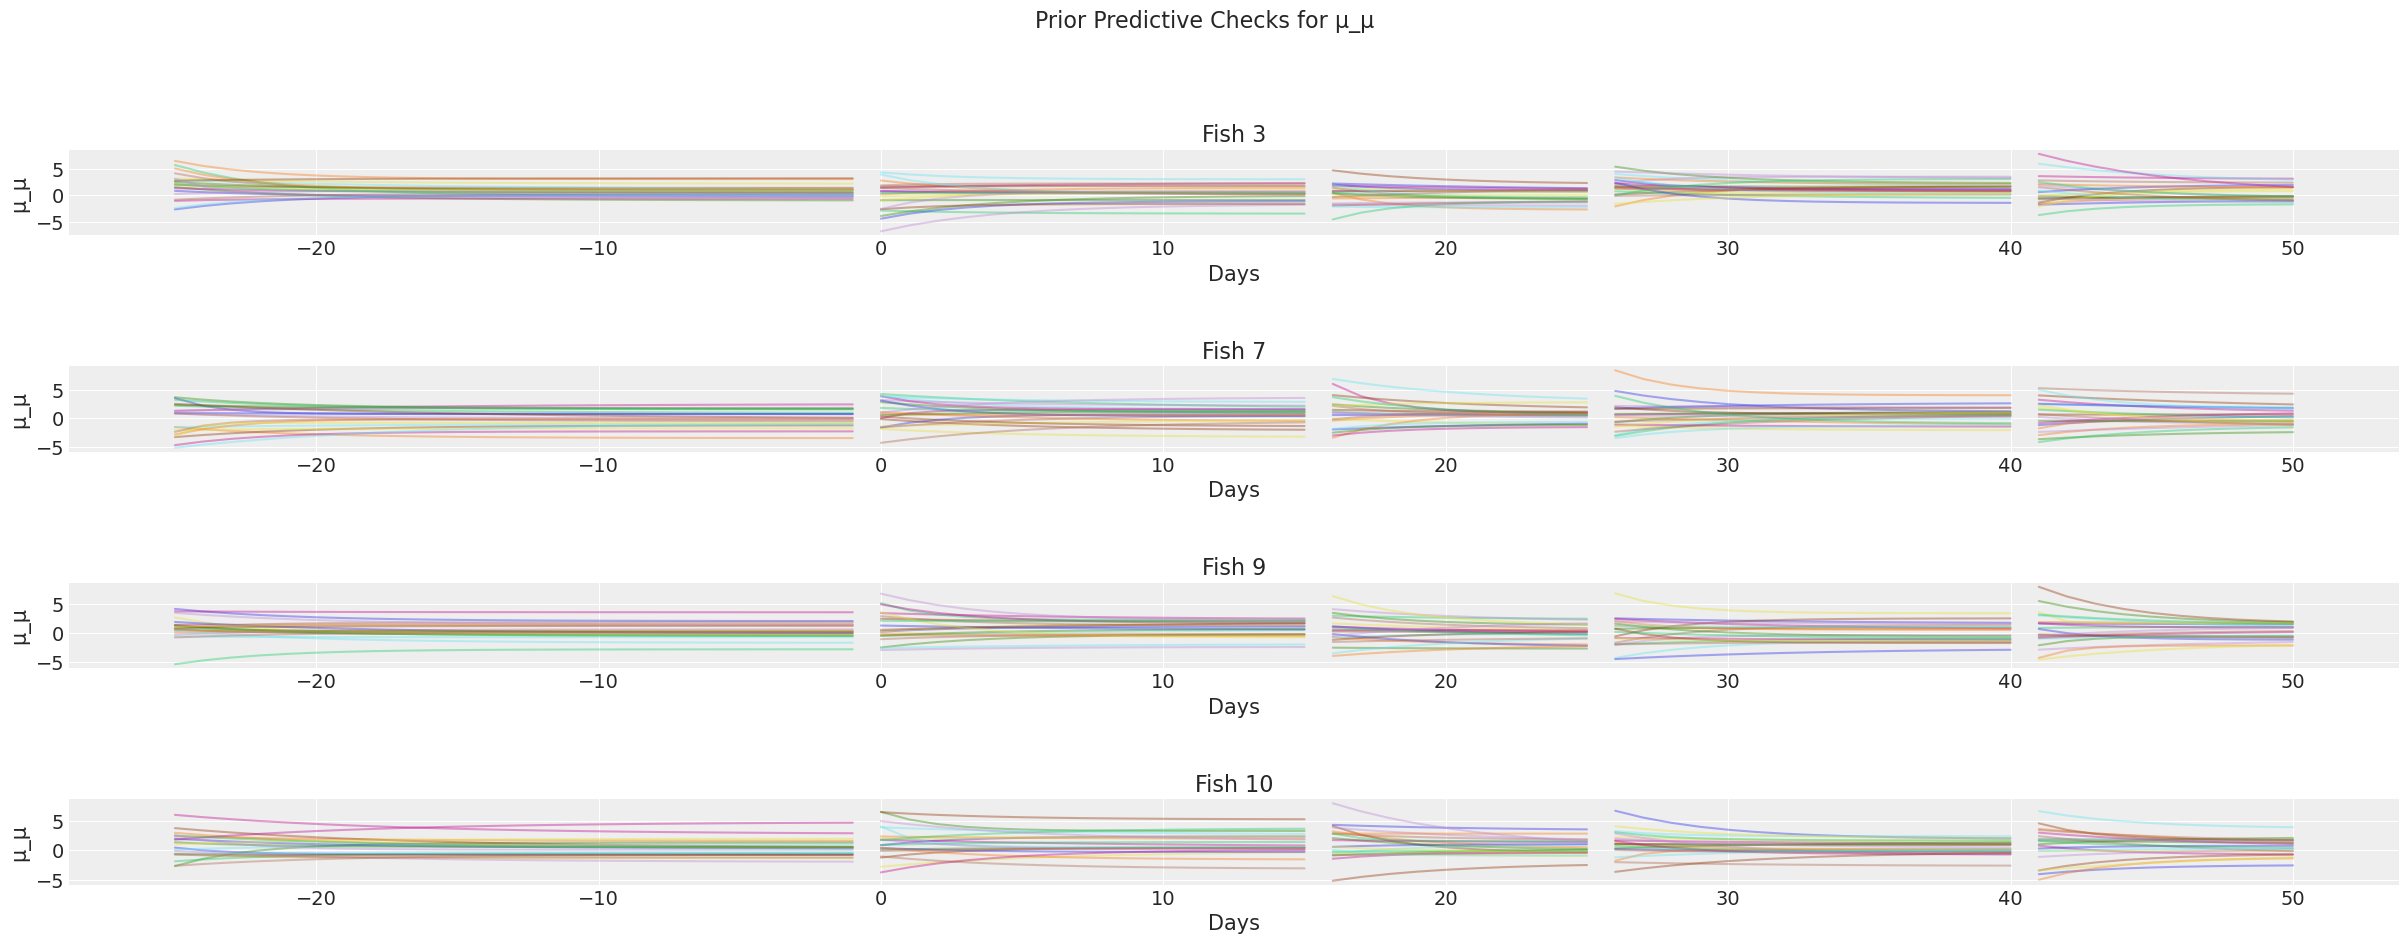

In [13]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")


C:\Users\86153\AppData\Local\Temp\ipykernel_34428\3239911825.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


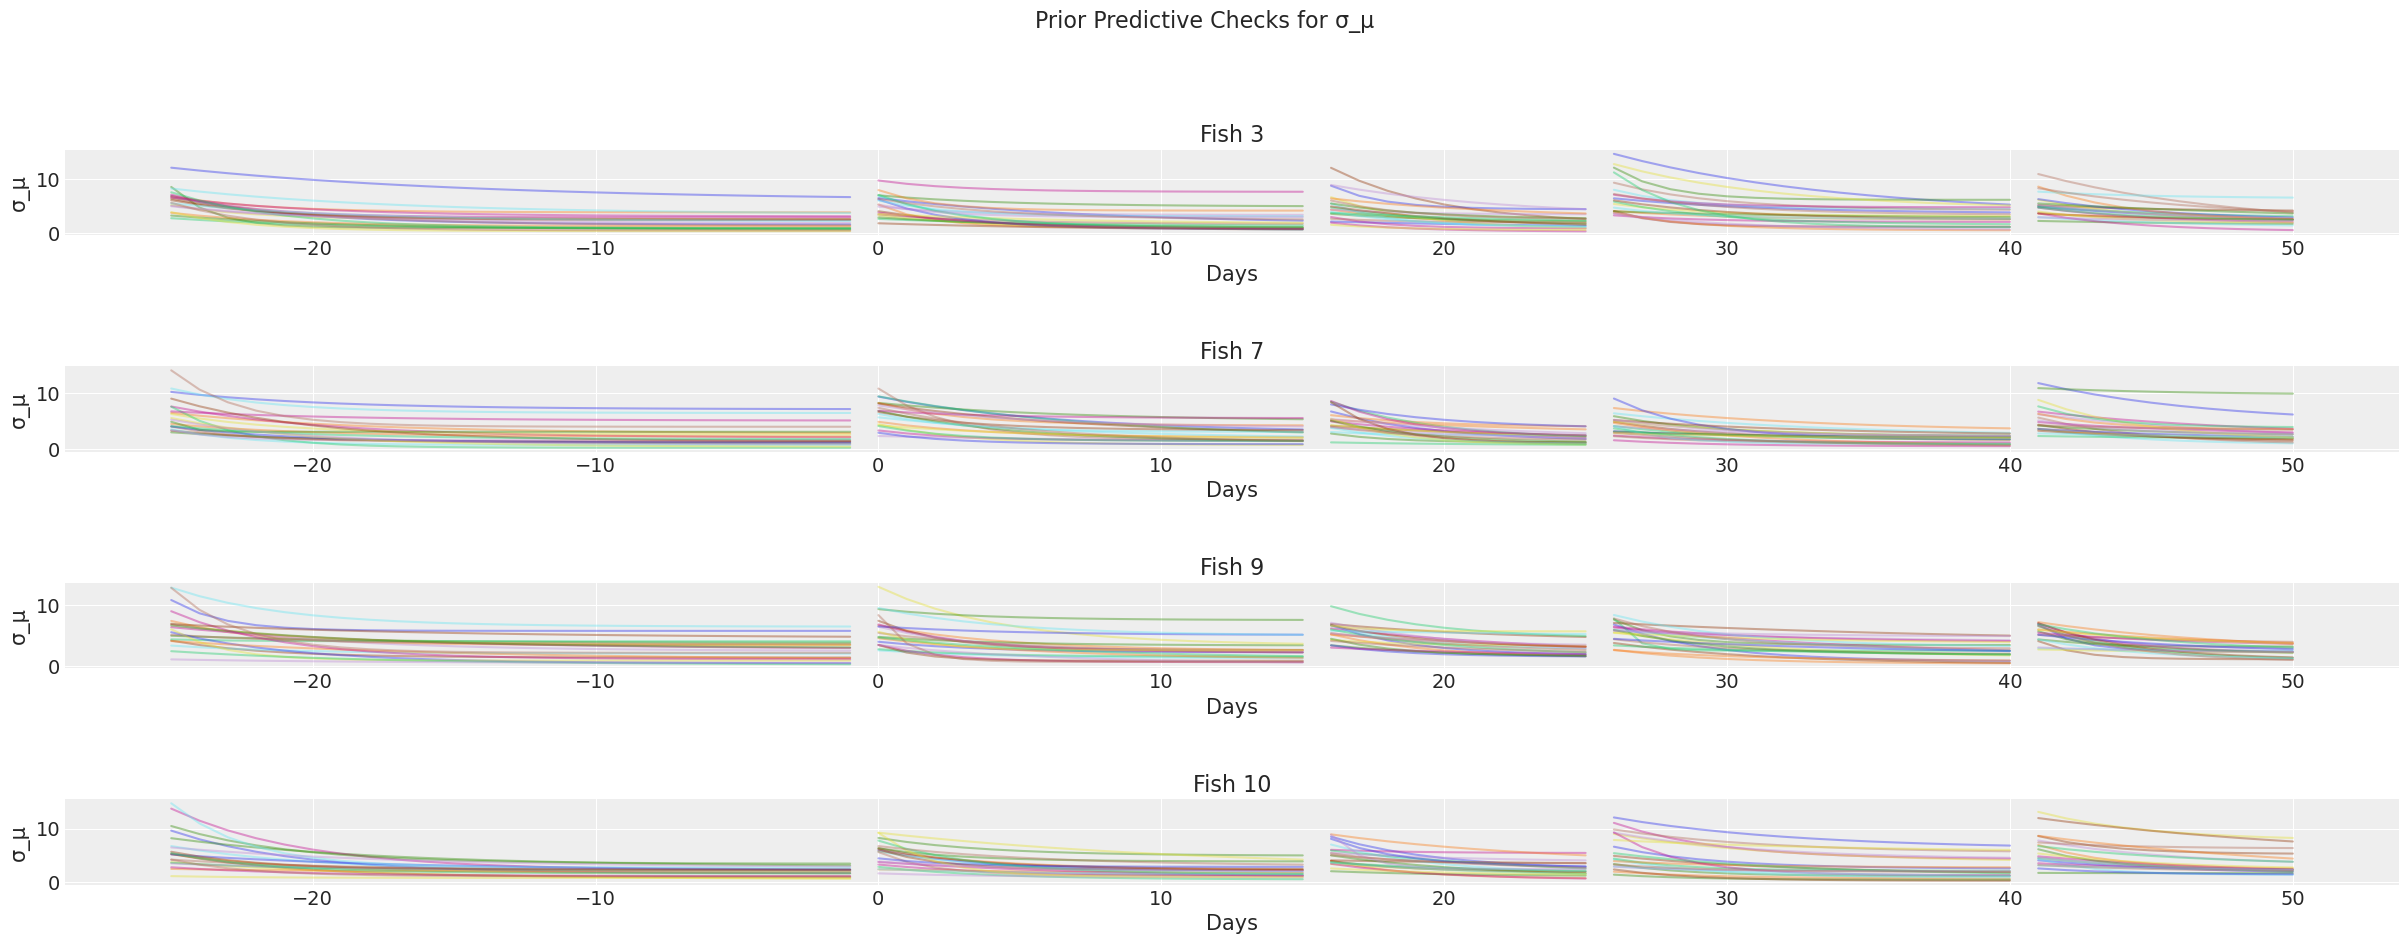

In [14]:
plot_hyperparameter_time_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [13]:
index_stage_map = {v: k for k, v in stage_index_map.items()}
day_range_ = xr.ones_like(cd.day_)
for i in day_range_['data']:
    stage_id = index_stage_map[cd.stage_[i].item()]
    day_range_[i] = day_ranges[stage_id][cd.day_[i].item()-1]


In [14]:
def plot_data_time_course_across_fish(day, data, data_name):
    plot_ds = xr.Dataset(data_vars={'day': day, 'data': data})

    fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

    plot_df = plot_ds.to_dataframe().reset_index()
    plot_df['day'] = plot_df['day'].astype(int)
    sns.violinplot(data=plot_df, x='day', y='data', ax=ax, inner='quartile')
    ax.set_title(f'{data_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{data_name}')

In [24]:
# plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'mu_y': prior['μ']})

# fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

# plot_df = plot_ds.to_dataframe().reset_index()
# plot_df['day'] = plot_df['day'].astype(int)
# sns.violinplot(data=plot_df, x='day', y='mu_y', ax=ax, inner='quartile')
# ax.set_title(f'Prior mu_y')
# ax.set_xlabel('Days')
# ax.set_ylabel('mu_yds')

Text(0, 0.5, 'sigma_yds')

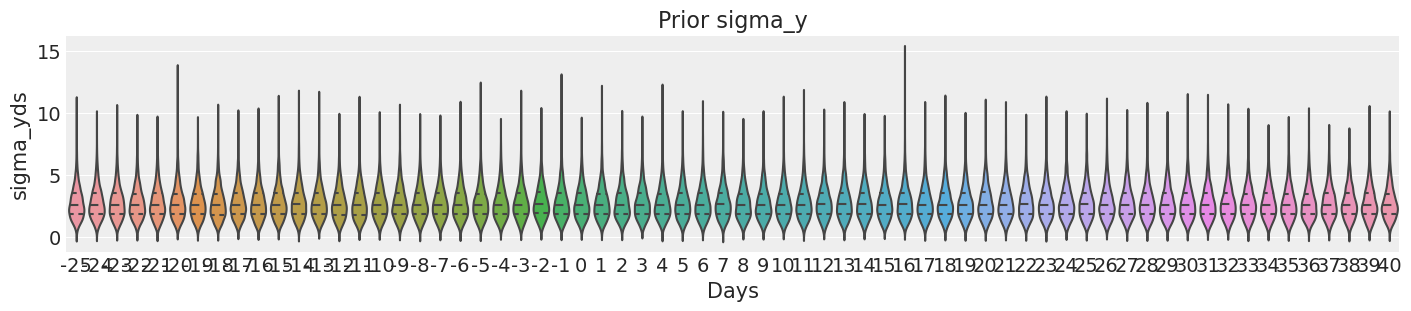

In [17]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'sigma_y': prior['σ']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='sigma_y', ax=ax, inner='quartile')
ax.set_title(f'Prior sigma_y')
ax.set_xlabel('Days')
ax.set_ylabel('sigma_yds')

Text(0, 0.5, 'Yds')

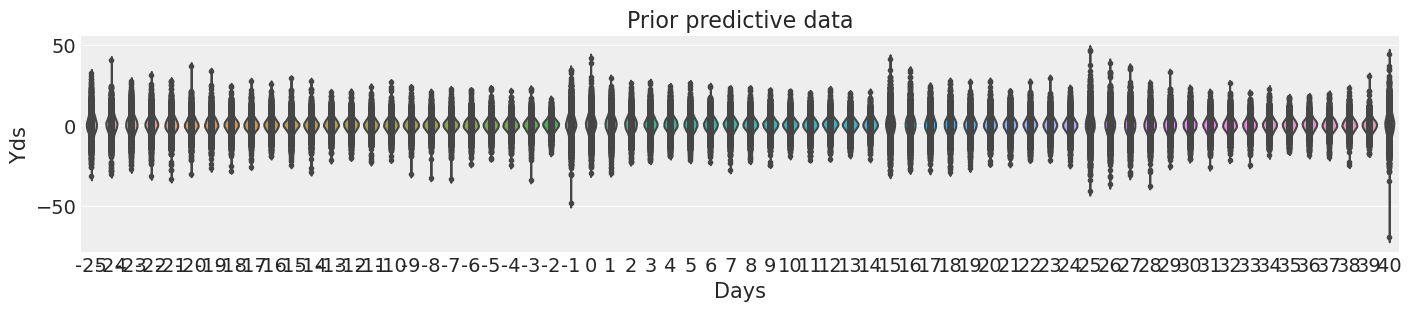

In [18]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'y_pp': pp['y']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='y_pp', ax=ax, inner='point')
ax.set_title(f'Prior predictive data')
ax.set_xlabel('Days')
ax.set_ylabel('Yds')

# Try different samplers


## NUTS sampler

In [16]:
# with m_yds:
#     id_yds.extend(pm.sample(1000, tune=1000, target_accept=0.95, nuts={'max_treedepth':15}), join='right')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [28]:
# az.summary(id_yds, var_names=['A_μμ', 'A_σμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[3, Rotation]   2.749  0.909   1.109    4.545      0.013    0.010   
A_μμ[7, Rotation]   0.342  0.972  -1.427    2.209      0.015    0.012   
A_μμ[9, Rotation]   2.699  1.529  -0.049    5.656      0.030    0.021   
A_μμ[10, Rotation]  2.005  1.184  -0.141    4.222      0.019    0.013   
A_σμ[3, Rotation]   1.280  0.725   0.175    2.599      0.012    0.008   
A_σμ[7, Rotation]   1.431  0.762   0.142    2.791      0.015    0.011   
A_σμ[9, Rotation]   2.257  1.248   0.289    4.536      0.026    0.019   
A_σμ[10, Rotation]  2.651  1.152   0.563    4.698      0.023    0.016   

                    ess_bulk  ess_tail  r_hat  
A_μμ[3, Rotation]     4746.0    3140.0    1.0  
A_μμ[7, Rotation]     4358.0    3273.0    1.0  
A_μμ[9, Rotation]     2549.0    3002.0    1.0  
A_μμ[10, Rotation]    3869.0    3162.0    1.0  
A_σμ[3, Rotation]     3651.0    3024.0    1.0  
A_σμ[7, Rotation]     2483.0    2494.0    1.0  
A_σμ[9, Rotation]     2320.0    2706.0    1.0  
A_σμ[10, Rotation]    2462.0    3078.0    1.0

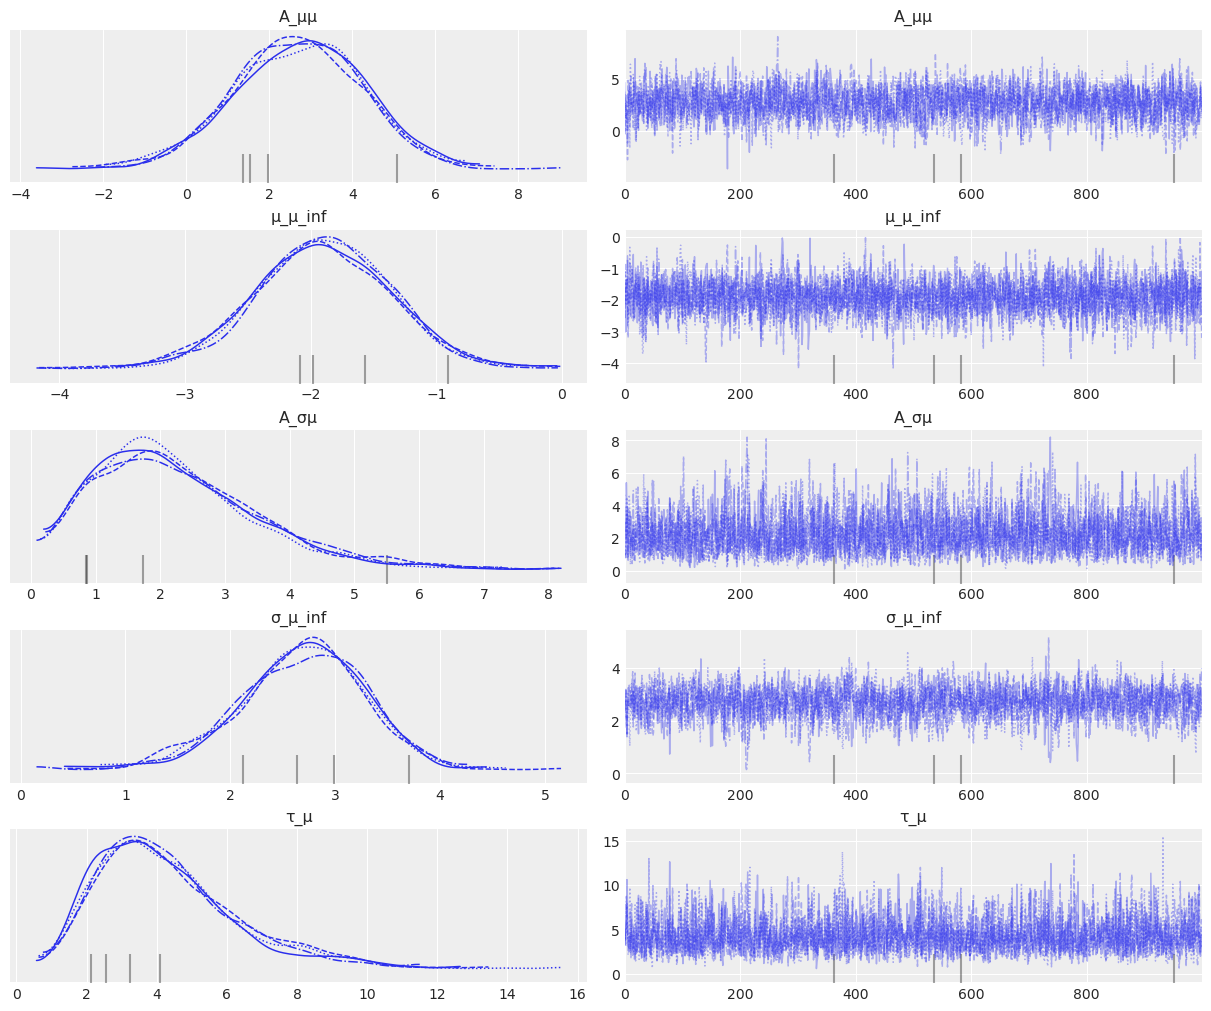

In [29]:
# az.plot_trace(id_yds, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

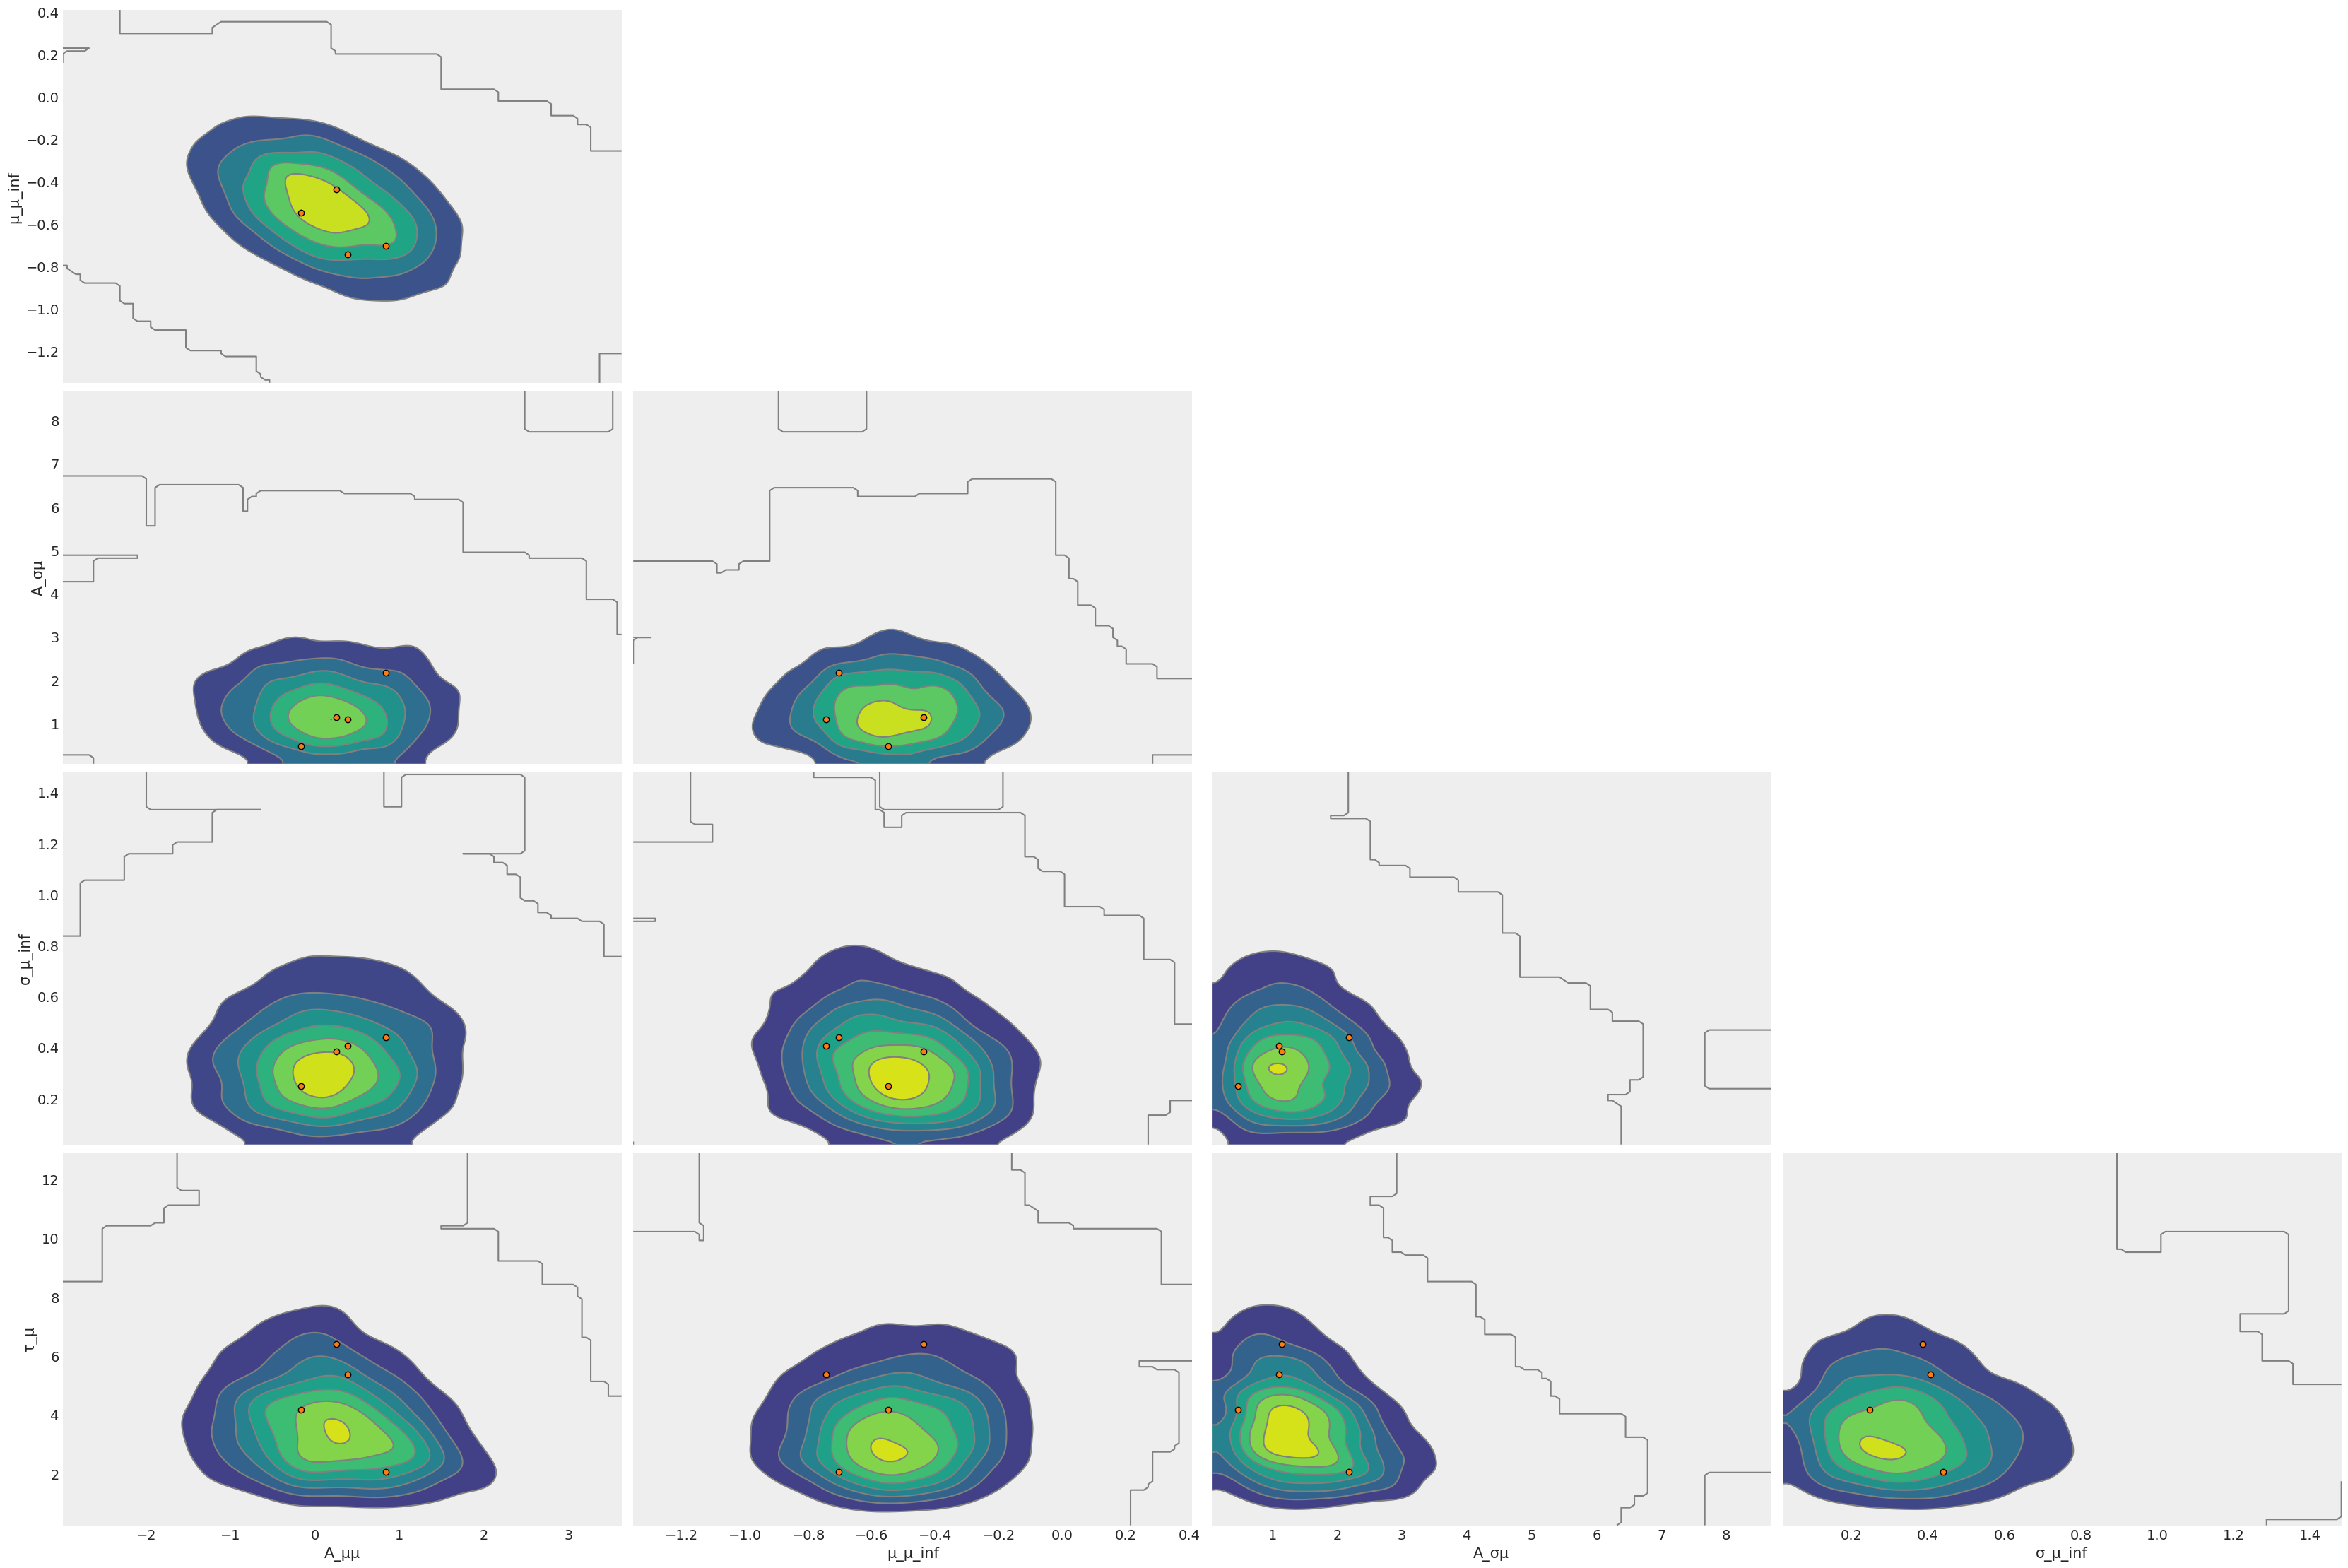

In [30]:
# az.plot_pair(id_yds, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
#              coords={'fish':10, 'stages': 'Baseline'}, 
#              divergences=True,
#              kind='kde');

## NumPyro JAX NUTS sampler

In [15]:
with m_yds:
    id_yds_numpyro = pm.sample(1000, tune=1000, target_accept=0.95, nuts_sampler="numpyro")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
az.summary(id_yds_numpyro, var_names=['A_μμ', 'A_σμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[3, Rotation]   2.720  0.961   0.890    4.497      0.017    0.012   
A_μμ[7, Rotation]   0.300  0.975  -1.454    2.211      0.020    0.015   
A_μμ[9, Rotation]   2.657  1.557  -0.277    5.669      0.037    0.026   
A_μμ[10, Rotation]  2.031  1.161  -0.070    4.284      0.021    0.015   
A_σμ[3, Rotation]   1.277  0.736   0.182    2.591      0.014    0.010   
A_σμ[7, Rotation]   1.435  0.778   0.181    2.837      0.015    0.011   
A_σμ[9, Rotation]   2.263  1.253   0.334    4.617      0.031    0.023   
A_σμ[10, Rotation]  2.637  1.138   0.647    4.794      0.025    0.017   

                    ess_bulk  ess_tail  r_hat  
A_μμ[3, Rotation]     3242.0    2923.0    1.0  
A_μμ[7, Rotation]     2457.0    2369.0    1.0  
A_μμ[9, Rotation]     1791.0    2020.0    1.0  
A_μμ[10, Rotation]    3059.0    3373.0    1.0  
A_σμ[3, Rotation]     2592.0    3116.0    1.0  
A_σμ[7, Rotation]     2453.0    2813.0    1.0  
A_σμ[9, Rotation]     1887.0    1594.0    1.0  
A_σμ[10, Rotation]    2016.0    2089.0    1.0

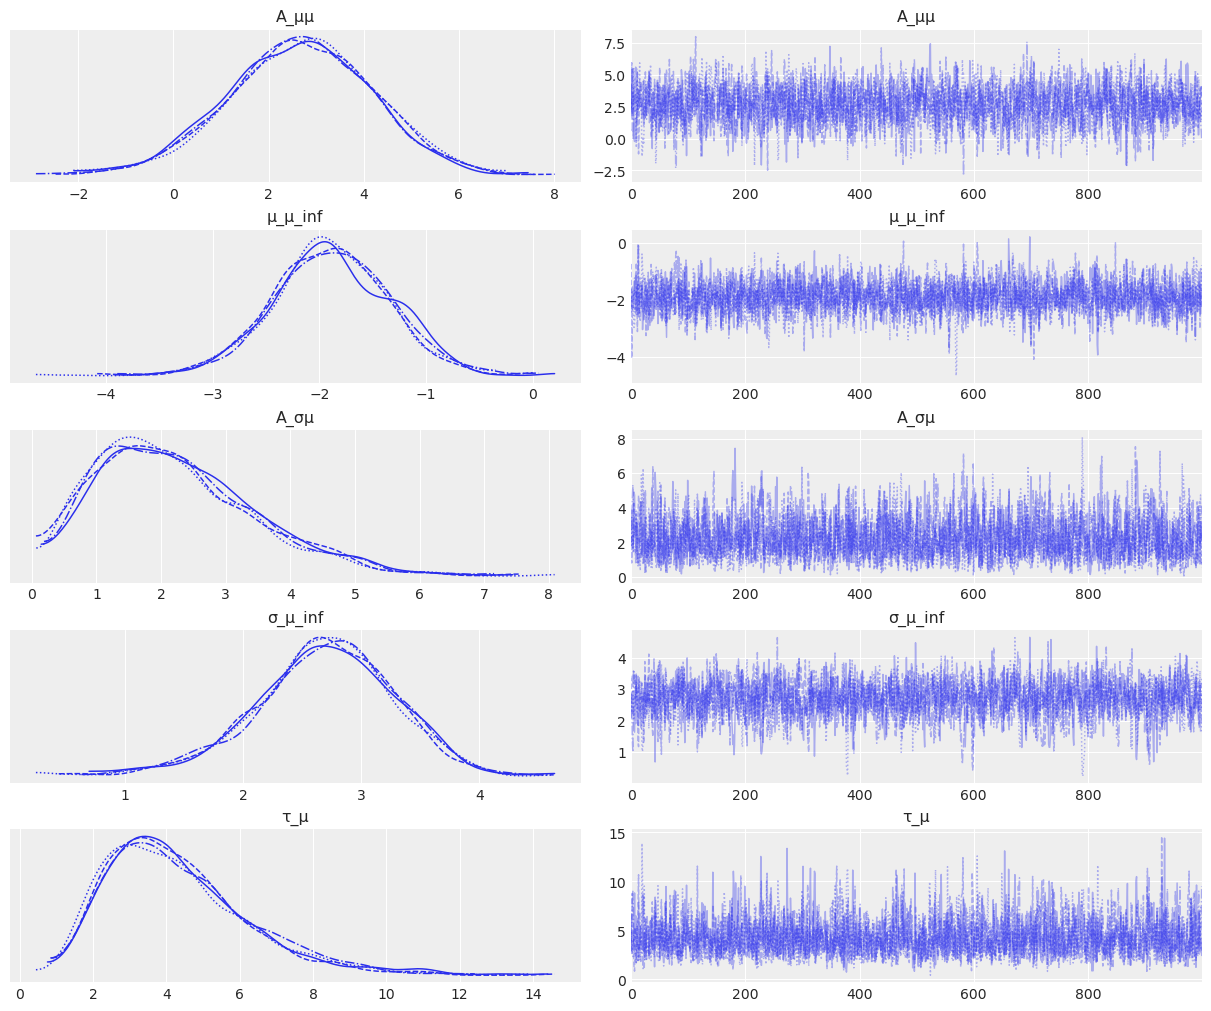

In [21]:
az.plot_trace(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

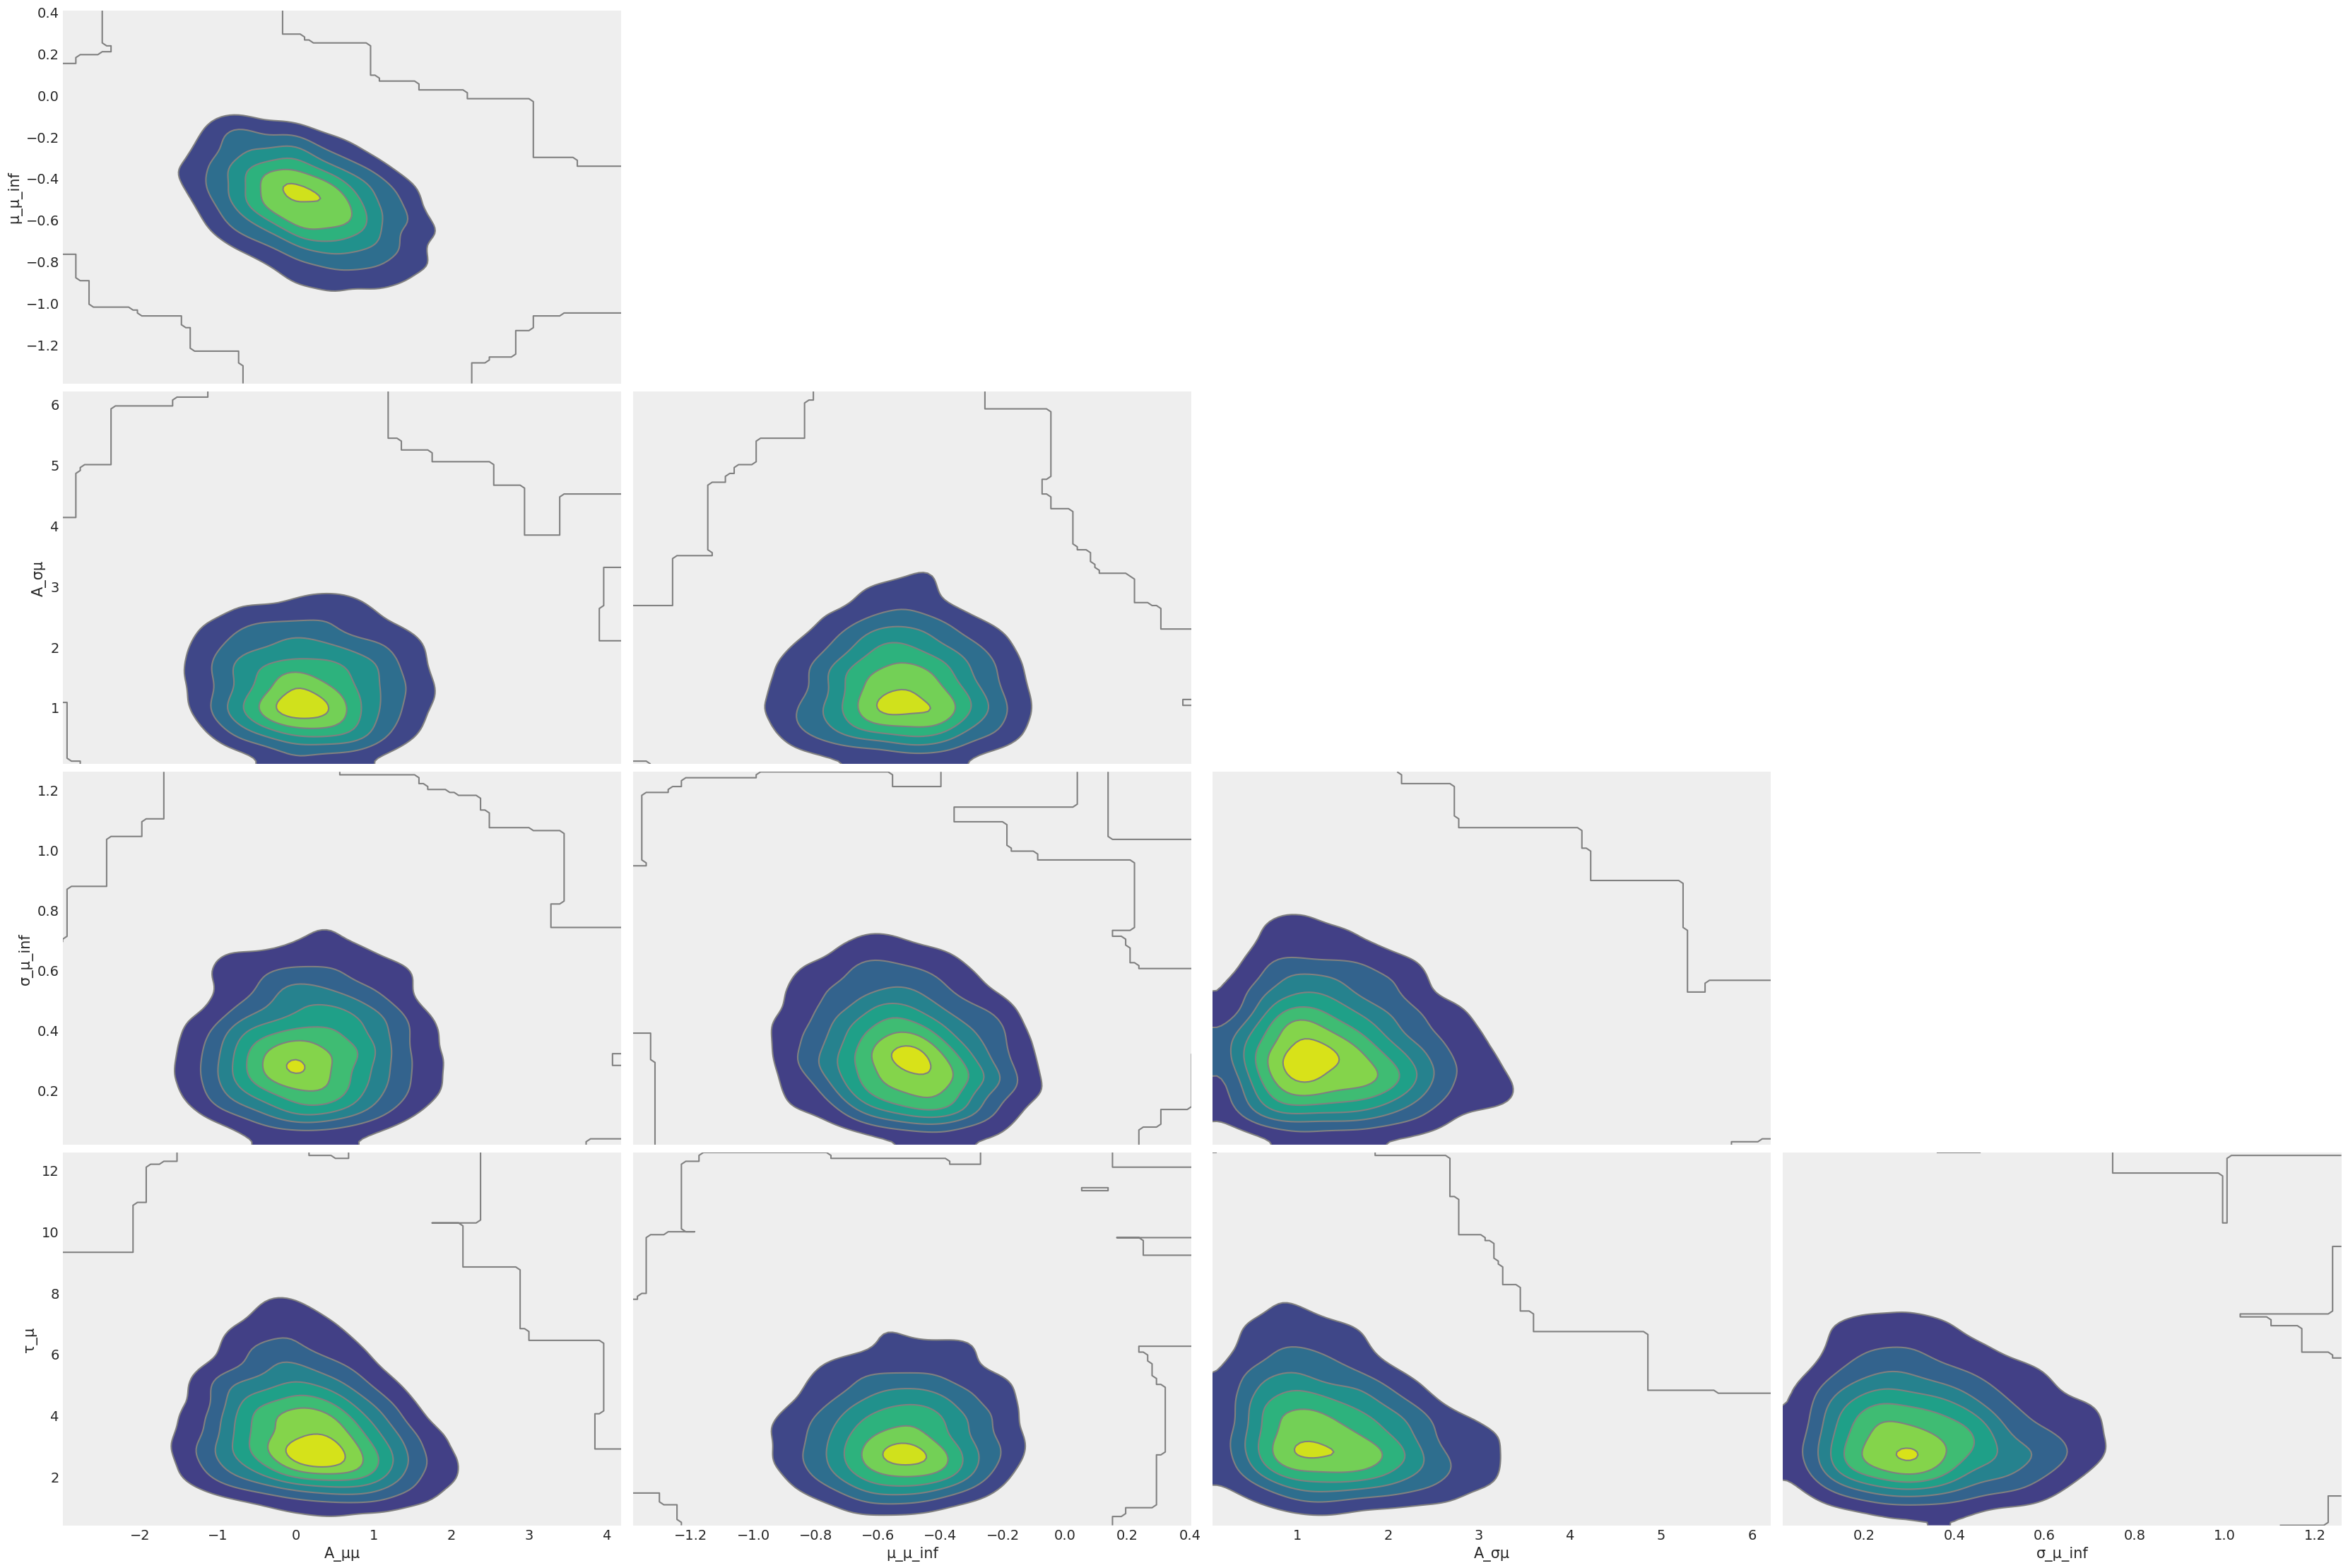

In [21]:
az.plot_pair(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
             coords={'fish':10, 'stages': 'Baseline'}, 
             divergences=True,
             kind='kde');

## BlackJAX NUTS sampler

In [ ]:
# with m_yds:
#     id_yds_blackjax = pm.sample(1000, tune=1000, target_accept=0.95,nuts_sampler="blackjax")

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\pymc\sampling\jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [36]:
# az.summary(id_yds_blackjax, var_names=['A_μμ', 'A_σμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[3, Rotation]   2.720  0.924   0.984    4.480      0.014    0.010   
A_μμ[7, Rotation]   0.345  0.964  -1.453    2.175      0.017    0.013   
A_μμ[9, Rotation]   2.685  1.515  -0.111    5.498      0.032    0.023   
A_μμ[10, Rotation]  2.031  1.180  -0.279    4.150      0.021    0.015   
A_σμ[3, Rotation]   1.289  0.732   0.179    2.600      0.013    0.009   
A_σμ[7, Rotation]   1.431  0.774   0.136    2.773      0.015    0.010   
A_σμ[9, Rotation]   2.248  1.213   0.299    4.457      0.028    0.020   
A_σμ[10, Rotation]  2.674  1.123   0.696    4.738      0.023    0.016   

                    ess_bulk  ess_tail  r_hat  
A_μμ[3, Rotation]     4573.0    3246.0    1.0  
A_μμ[7, Rotation]     3228.0    3321.0    1.0  
A_μμ[9, Rotation]     2236.0    3040.0    1.0  
A_μμ[10, Rotation]    3234.0    2891.0    1.0  
A_σμ[3, Rotation]     2873.0    2618.0    1.0  
A_σμ[7, Rotation]     2776.0    2502.0    1.0  
A_σμ[9, Rotation]     2047.0    2648.0    1.0  
A_σμ[10, Rotation]    2305.0    2832.0    1.0

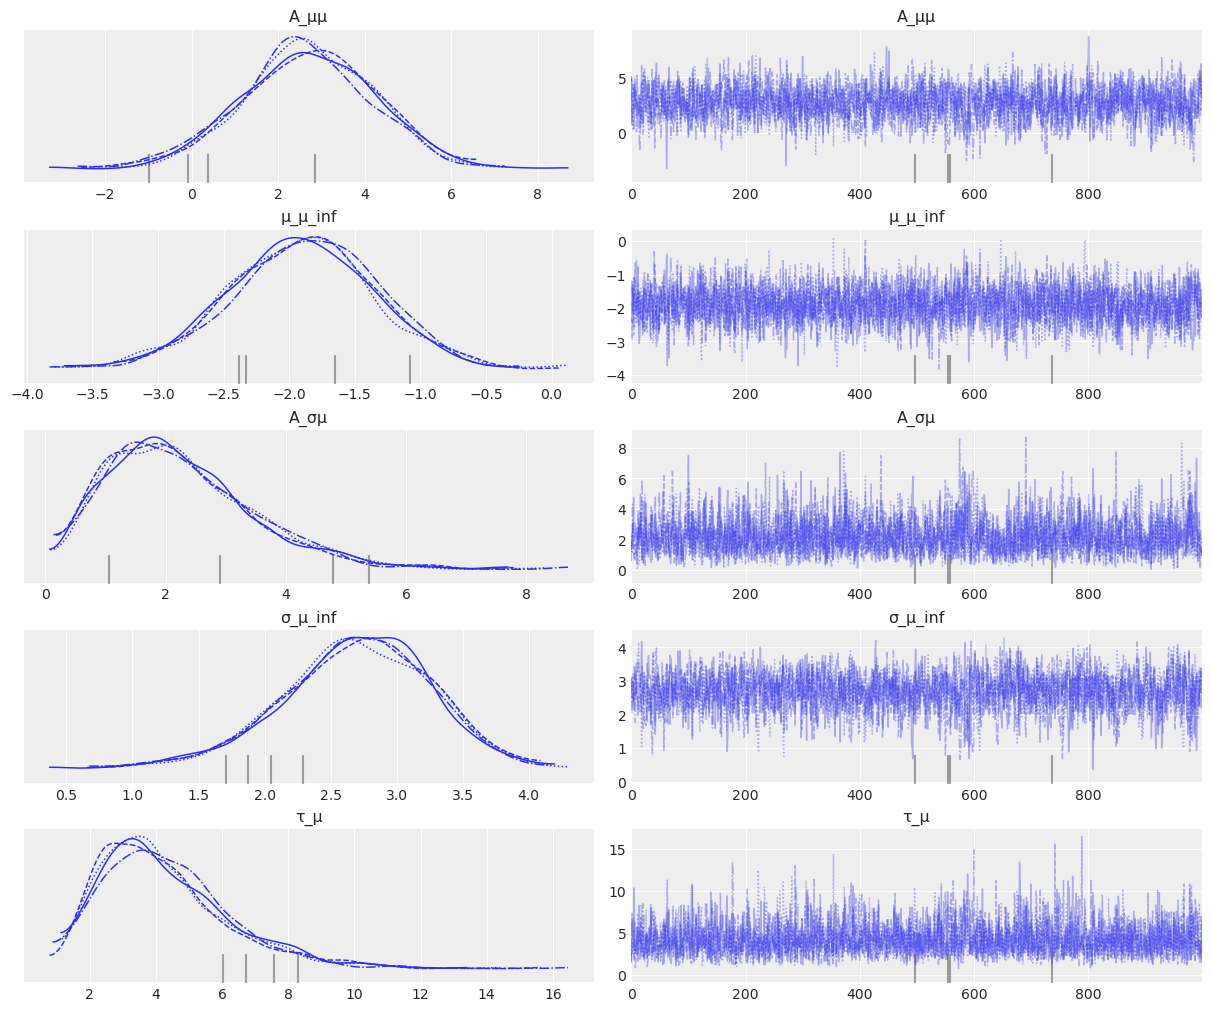

In [37]:
# az.plot_trace(id_yds_blackjax, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

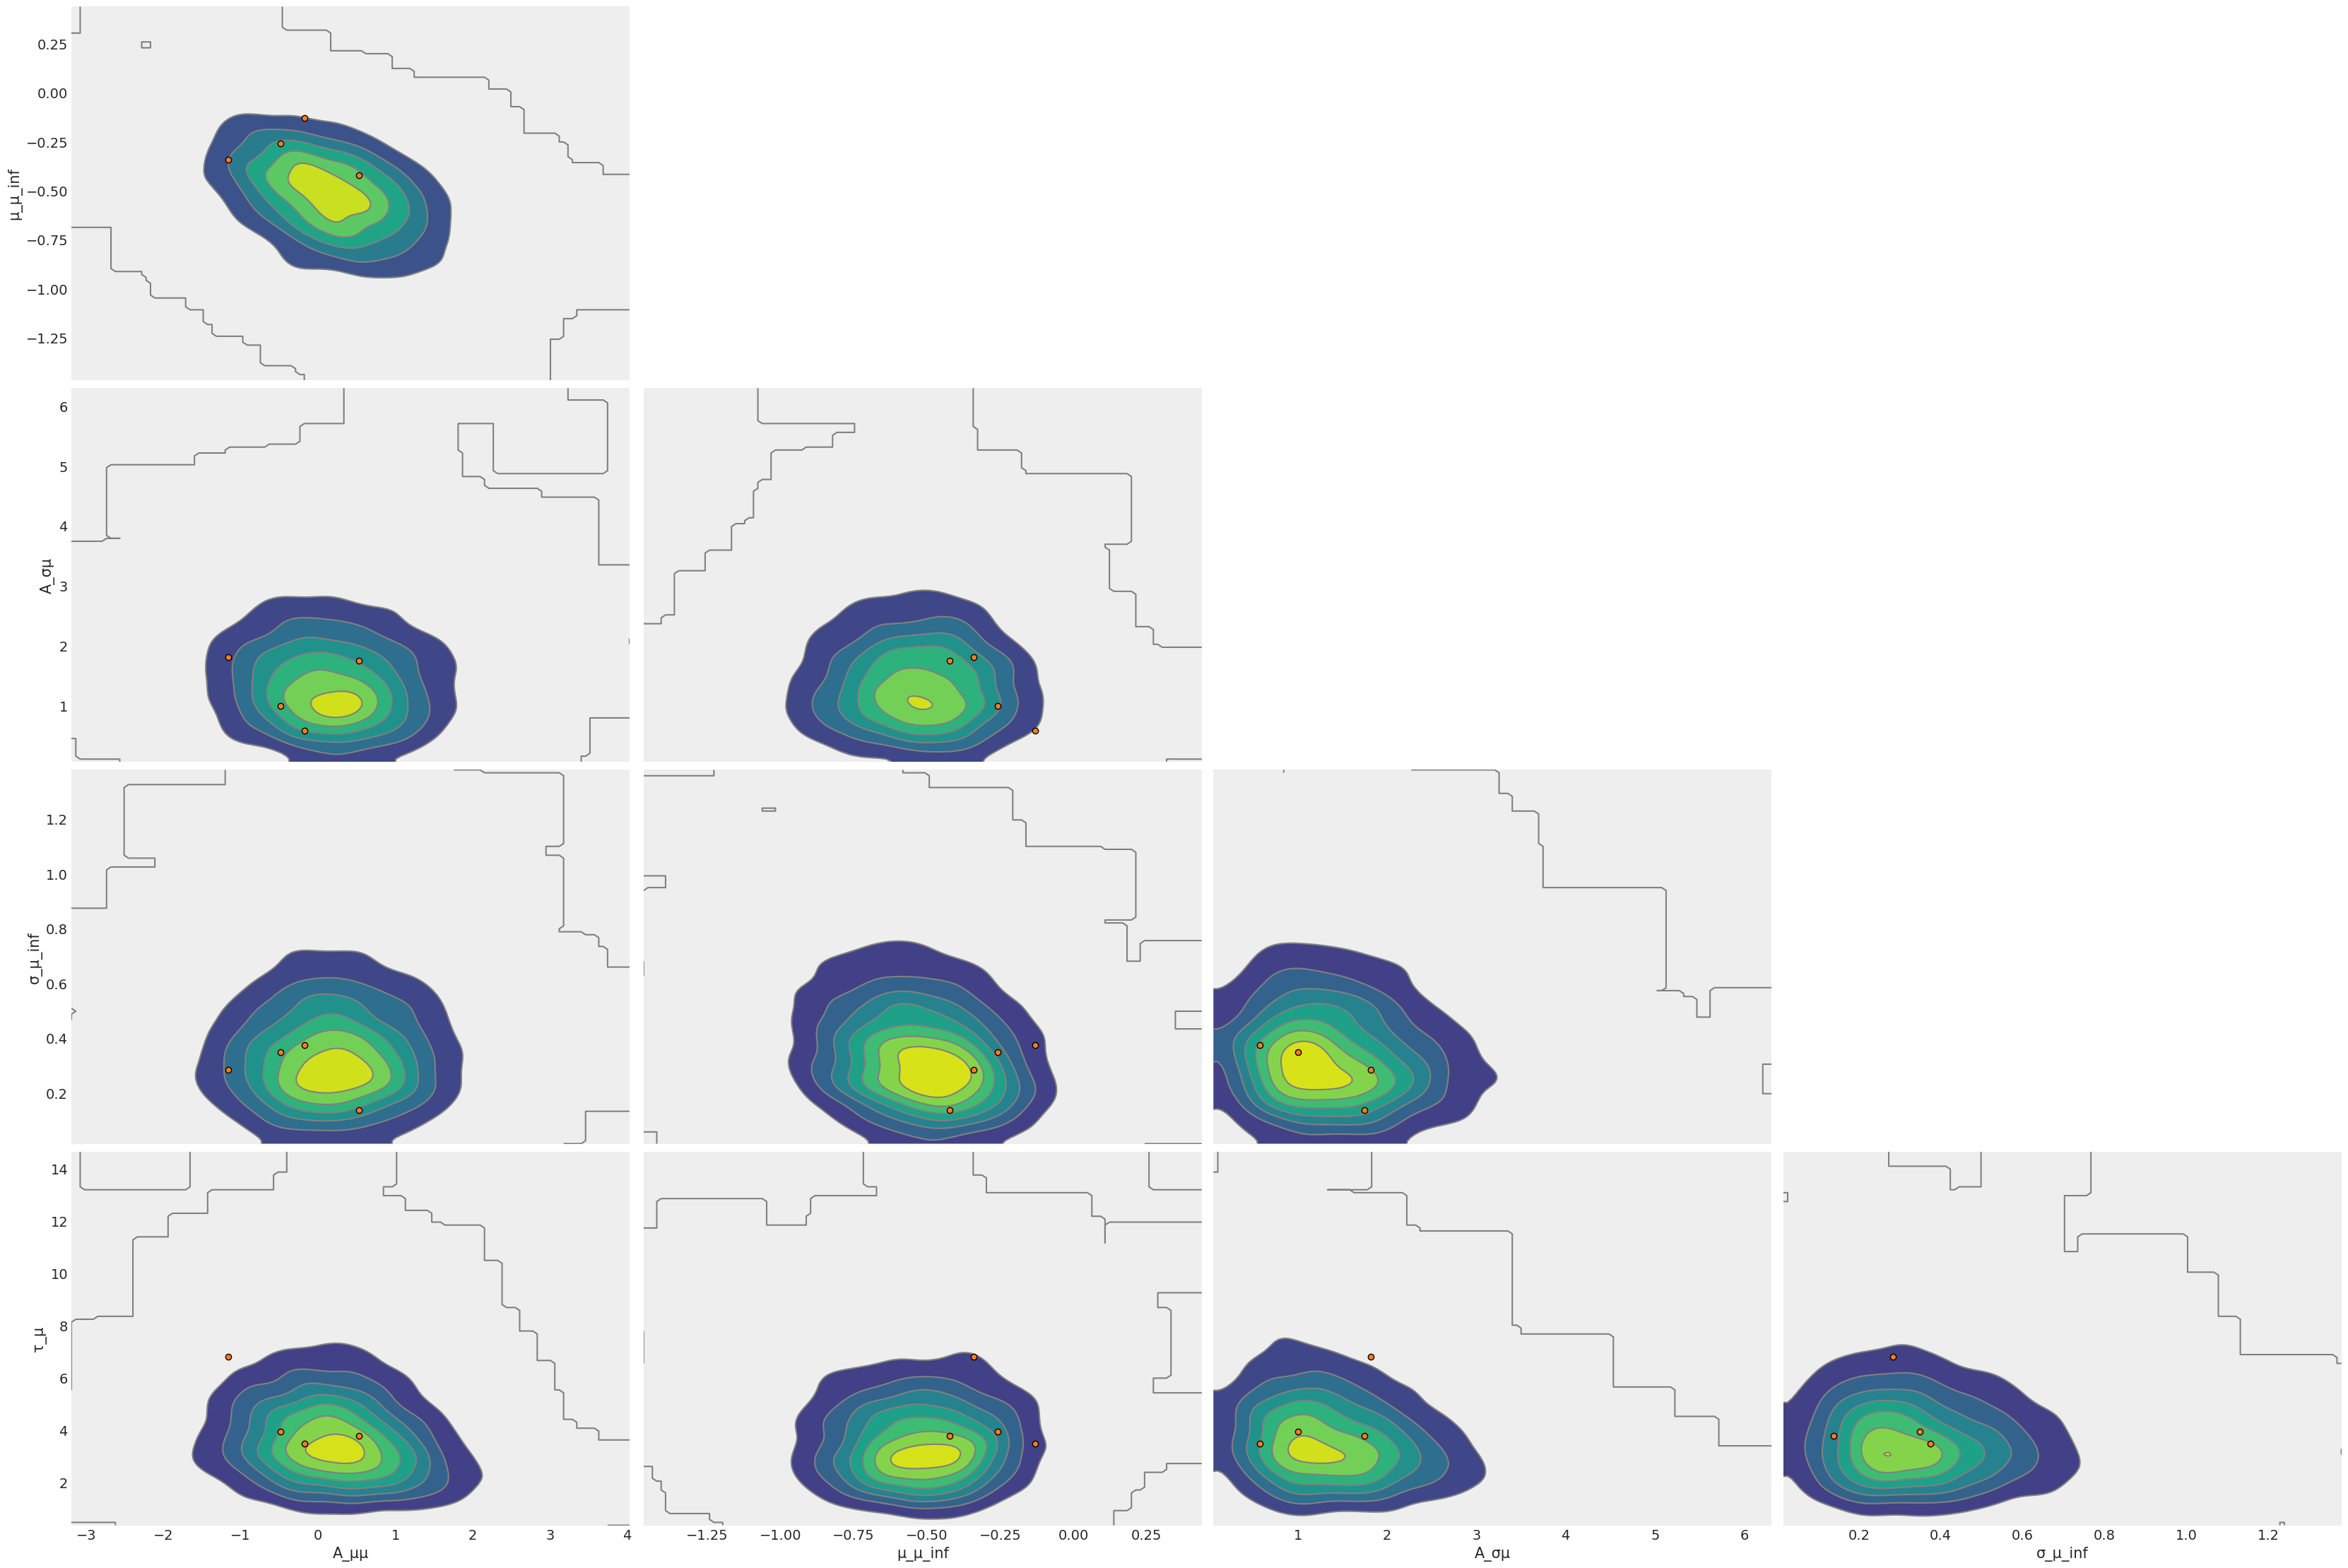

In [38]:
# az.plot_pair(id_yds_blackjax, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
#              coords={'fish':10, 'stages': 'Baseline'}, 
#              divergences=True,
#              kind='kde');

## Nutpie Rust NUTS sampler

In [39]:
# with m_yds:
#     id_yds_nutpie = pm.sample(1000, tune=1000, target_accept=0.95,nuts_sampler="nutpie")

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\numba\dispatch\basic.py:373: UserWarning: Numba will use object mode to run AdvancedSubtensor's perform method
  warnings.warn(
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\numba\dispatch\basic.py:373: UserWarning: Numba will use object mode to run AdvancedSubtensor's perform method
  warnings.warn(
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\numba\dispatch\basic.py:373: UserWarning: Numba will use object mode to run AdvancedSubtensor's perform method
  warnings.warn(
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\numba\dispatch\basic.py:373: UserWarning: Numba will use object mode to run AdvancedIncSubtensor's perform method
  warnings.warn(
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\numba\dispatch\basic.py:373: UserWarning: Numba will use object mode to run AdvancedSubtensor's perform method
  warnings.warn(
c:

In [40]:
# az.summary(id_yds_nutpie, var_names=['A_μμ', 'A_σμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[3, Rotation]   2.733  0.905   1.008    4.439      0.015    0.011   
A_μμ[7, Rotation]   0.332  0.954  -1.361    2.276      0.020    0.014   
A_μμ[9, Rotation]   2.674  1.530  -0.194    5.568      0.043    0.030   
A_μμ[10, Rotation]  2.036  1.175  -0.239    4.125      0.026    0.018   
A_σμ[3, Rotation]   1.259  0.725   0.121    2.551      0.015    0.011   
A_σμ[7, Rotation]   1.434  0.753   0.192    2.822      0.016    0.011   
A_σμ[9, Rotation]   2.264  1.226   0.268    4.440      0.036    0.026   
A_σμ[10, Rotation]  2.600  1.119   0.571    4.628      0.025    0.017   

                    ess_bulk  ess_tail  r_hat  
A_μμ[3, Rotation]     3514.0    2787.0    1.0  
A_μμ[7, Rotation]     2259.0    2650.0    1.0  
A_μμ[9, Rotation]     1268.0    2212.0    1.0  
A_μμ[10, Rotation]    2059.0    2746.0    1.0  
A_σμ[3, Rotation]     2220.0    2313.0    1.0  
A_σμ[7, Rotation]     2264.0    2287.0    1.0  
A_σμ[9, Rotation]     1245.0    1527.0    1.0  
A_σμ[10, Rotation]    1951.0    2065.0    1.0

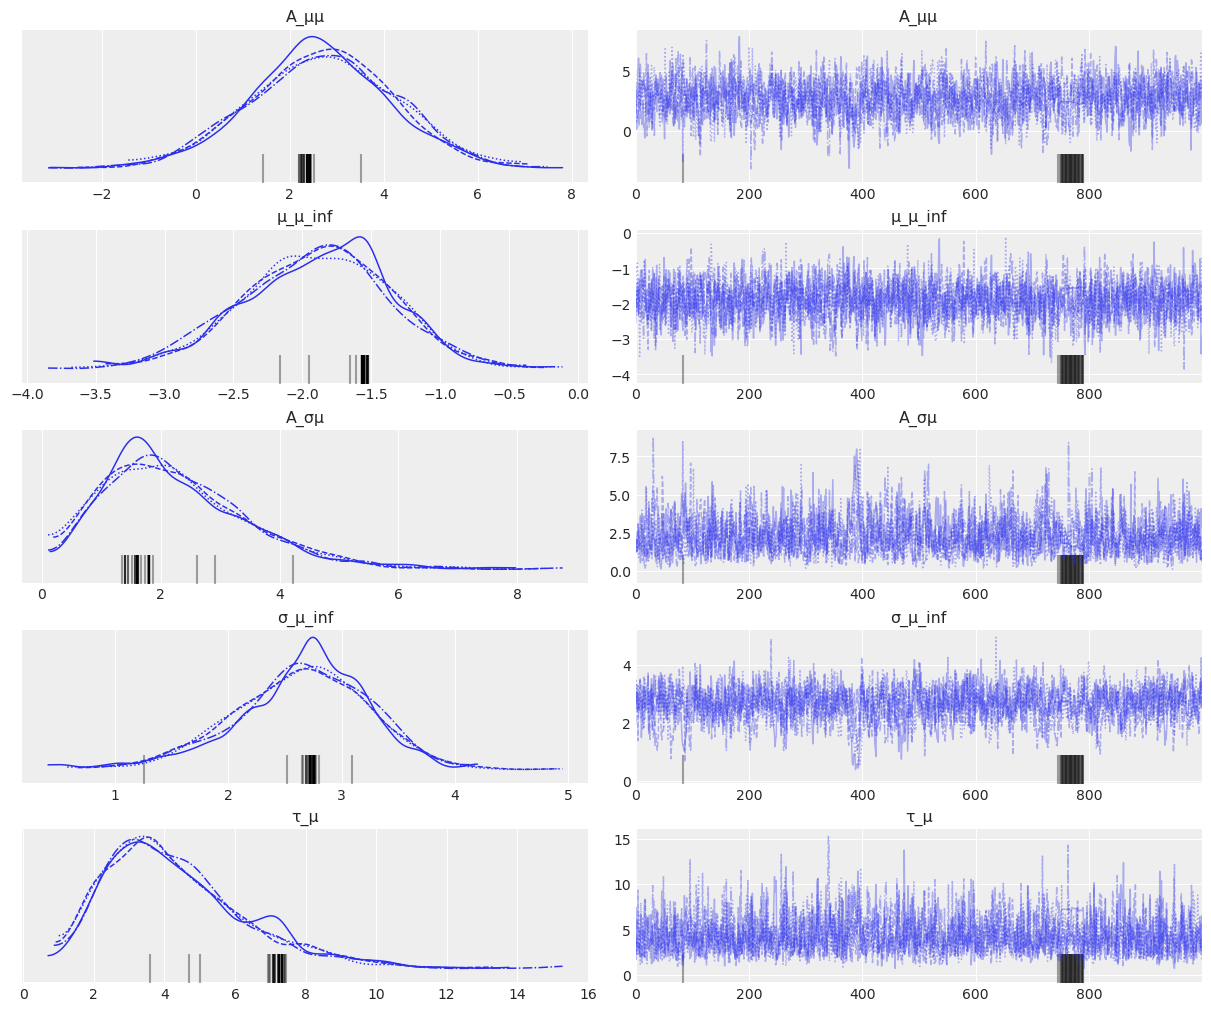

In [41]:
# az.plot_trace(id_yds_nutpie, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

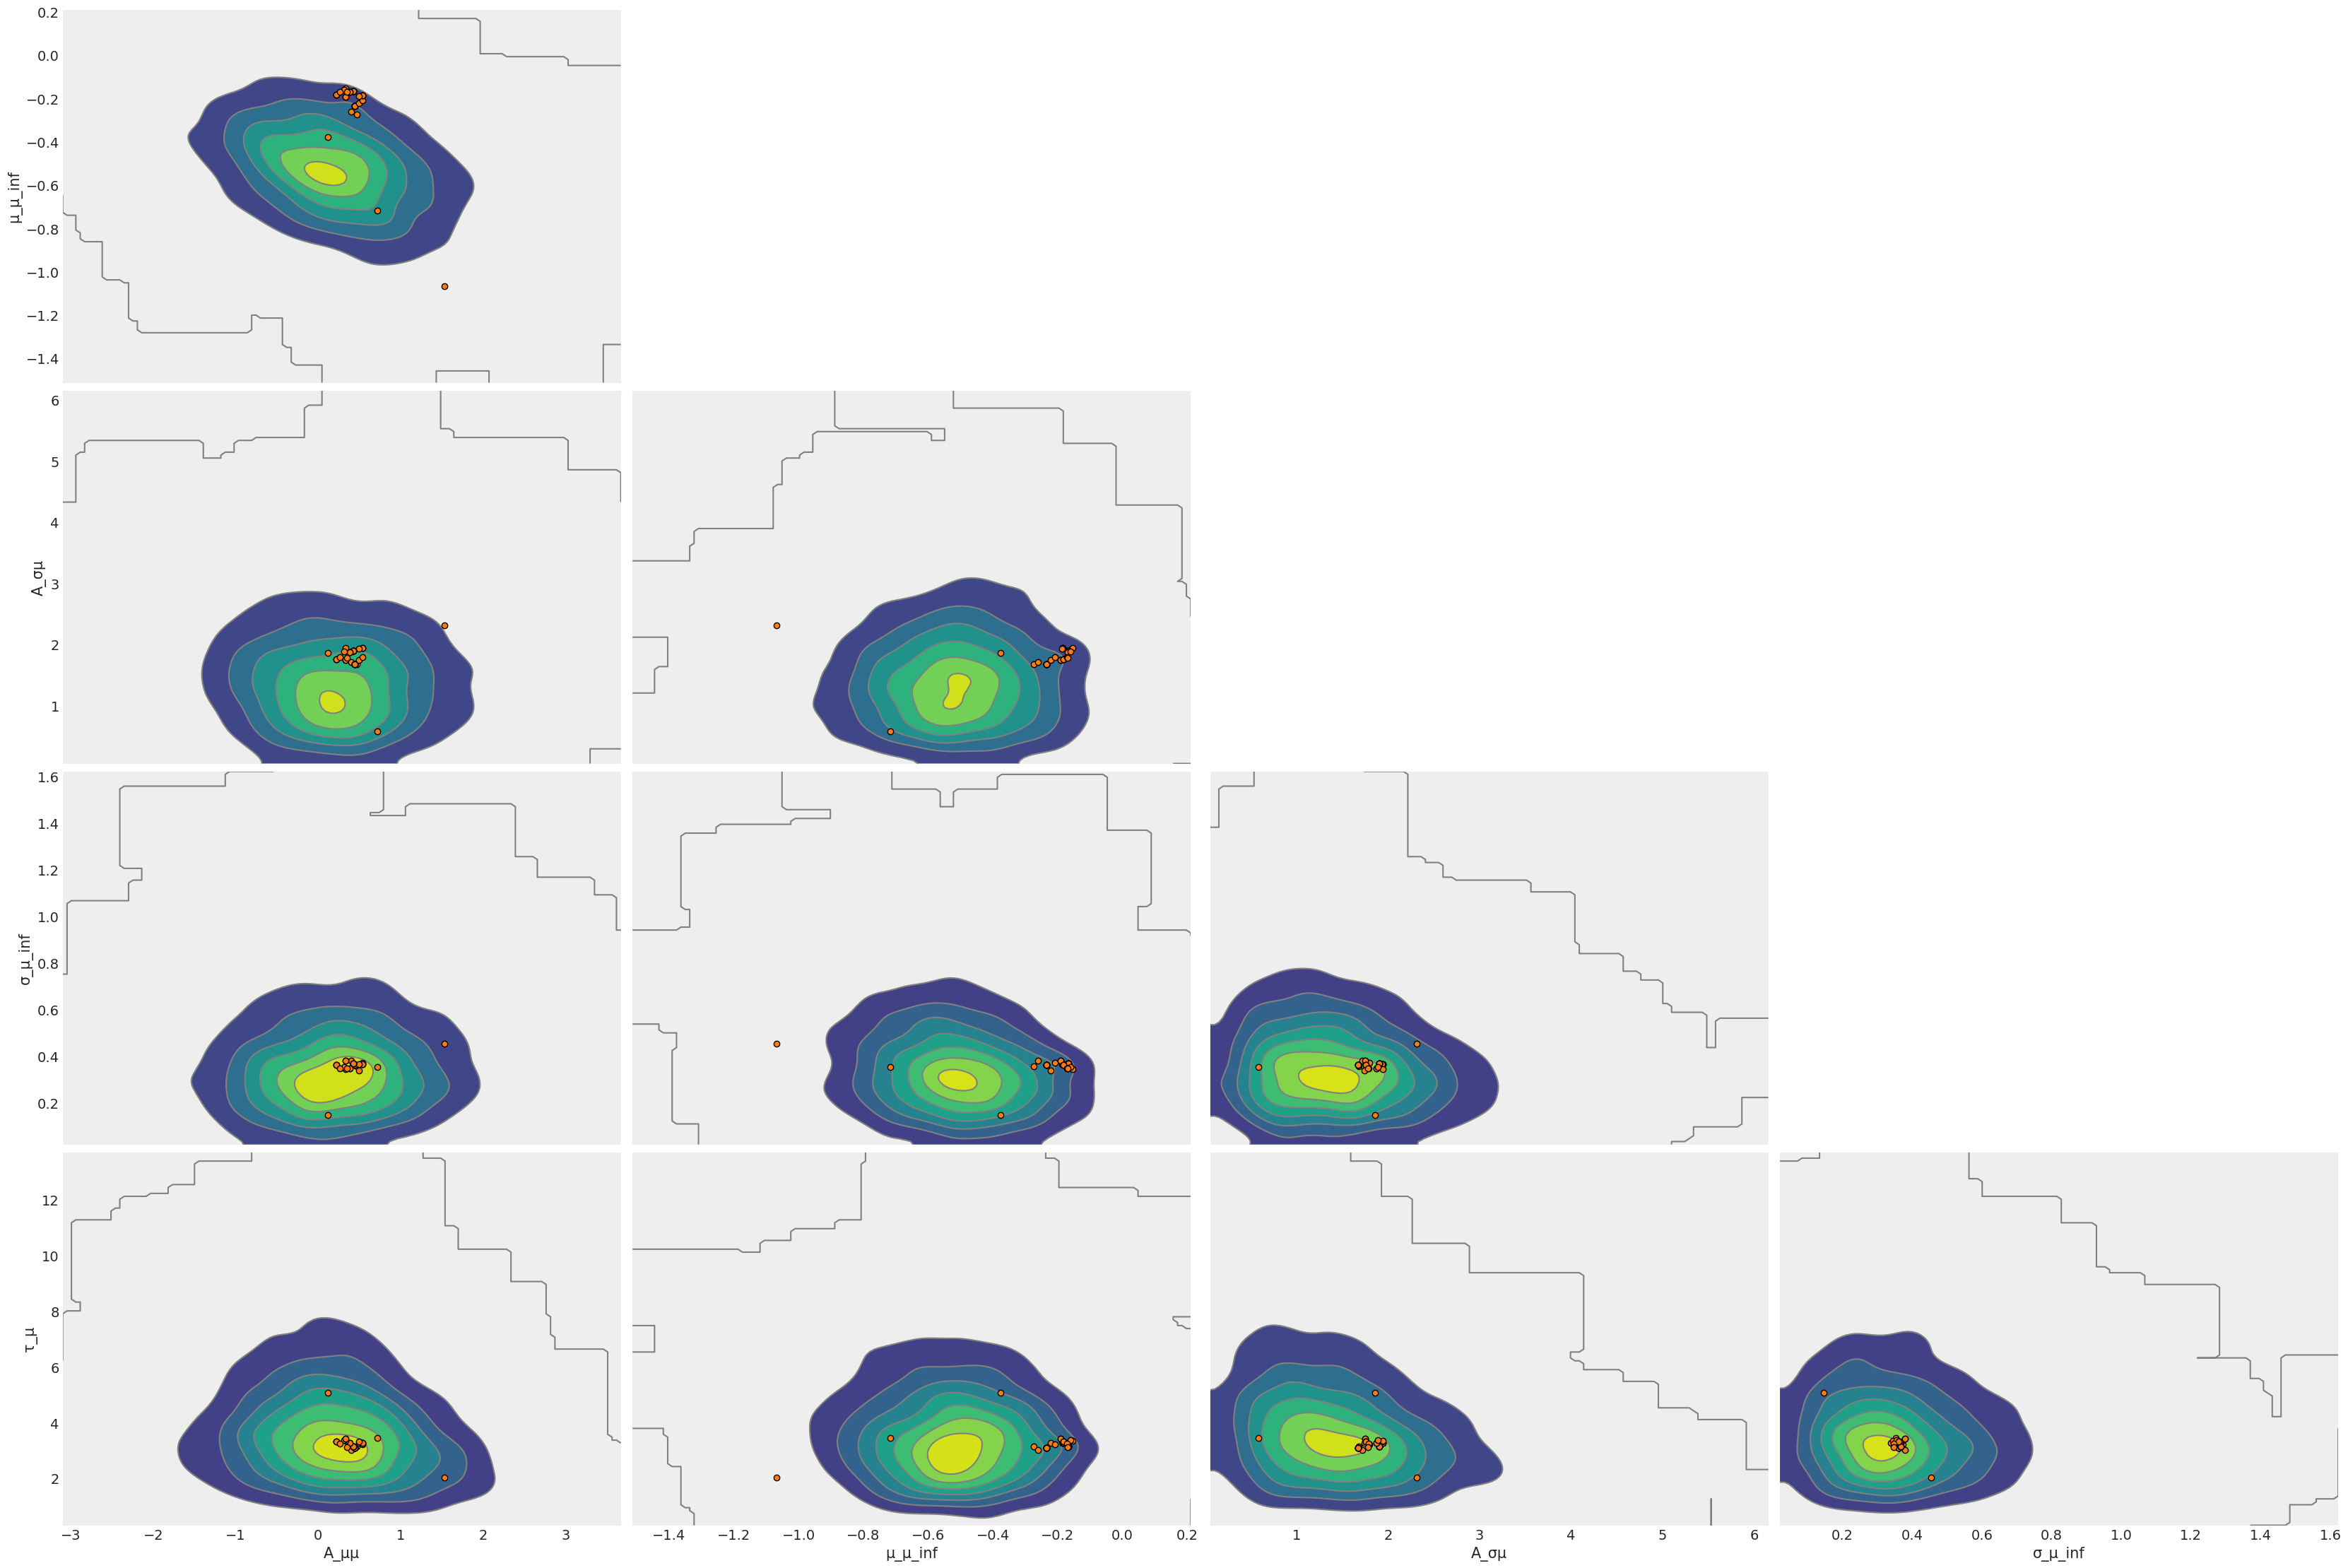

In [42]:
# az.plot_pair(id_yds_nutpie, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
#              coords={'fish':10, 'stages': 'Baseline'}, 
#              divergences=True,
#              kind='kde');

## Prior preditive plots

In [16]:
with m_yds:
    pm.sample_posterior_predictive(id_yds_numpyro, extend_inferencedata=True)

Sampling: [y]


In [17]:

posterior = id_yds_numpyro.posterior
ppc = id_yds_numpyro.posterior_predictive
cd = id_yds_numpyro.constant_data
obd = id_yds_numpyro.observed_data


In [18]:
def plot_hyperparameter_ppc_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 10)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(posterior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            posterior_fs = posterior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = posterior_fs[A_param]
            inf_fs = posterior_fs[inf_param]
            τ_fs = posterior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            ppc_param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index]  # Get the specific subplot
            for draw_idx in range(num_draws_to_plot):
                ax.plot(day_ranges[stage_id], ppc_param_vals.values.T[:, draw_idx, 1], alpha=0.4, label=f"Draw {draw_idx + 1}")

            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Posterior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_7212\1467832152.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


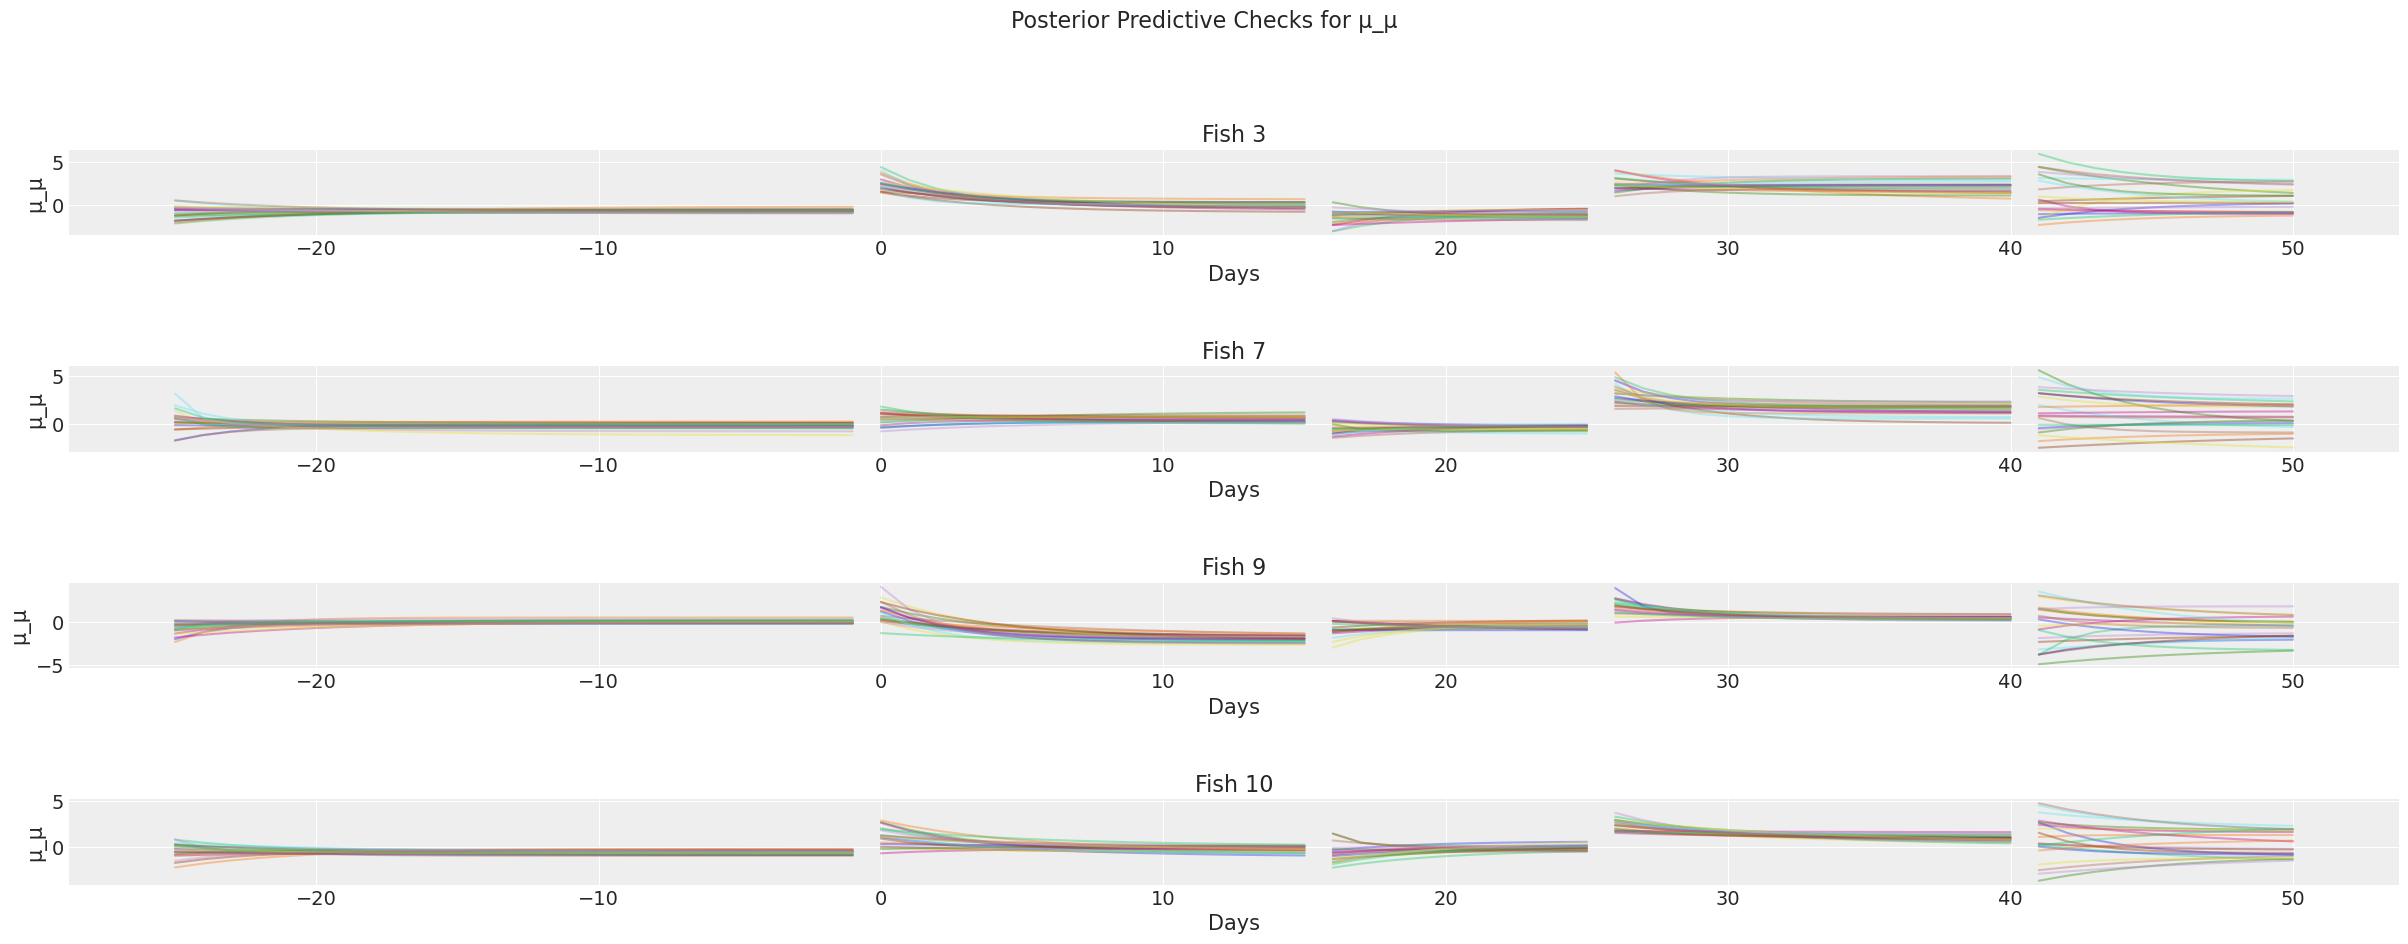

In [19]:
plot_hyperparameter_ppc_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

C:\Users\86153\AppData\Local\Temp\ipykernel_34300\1467832152.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


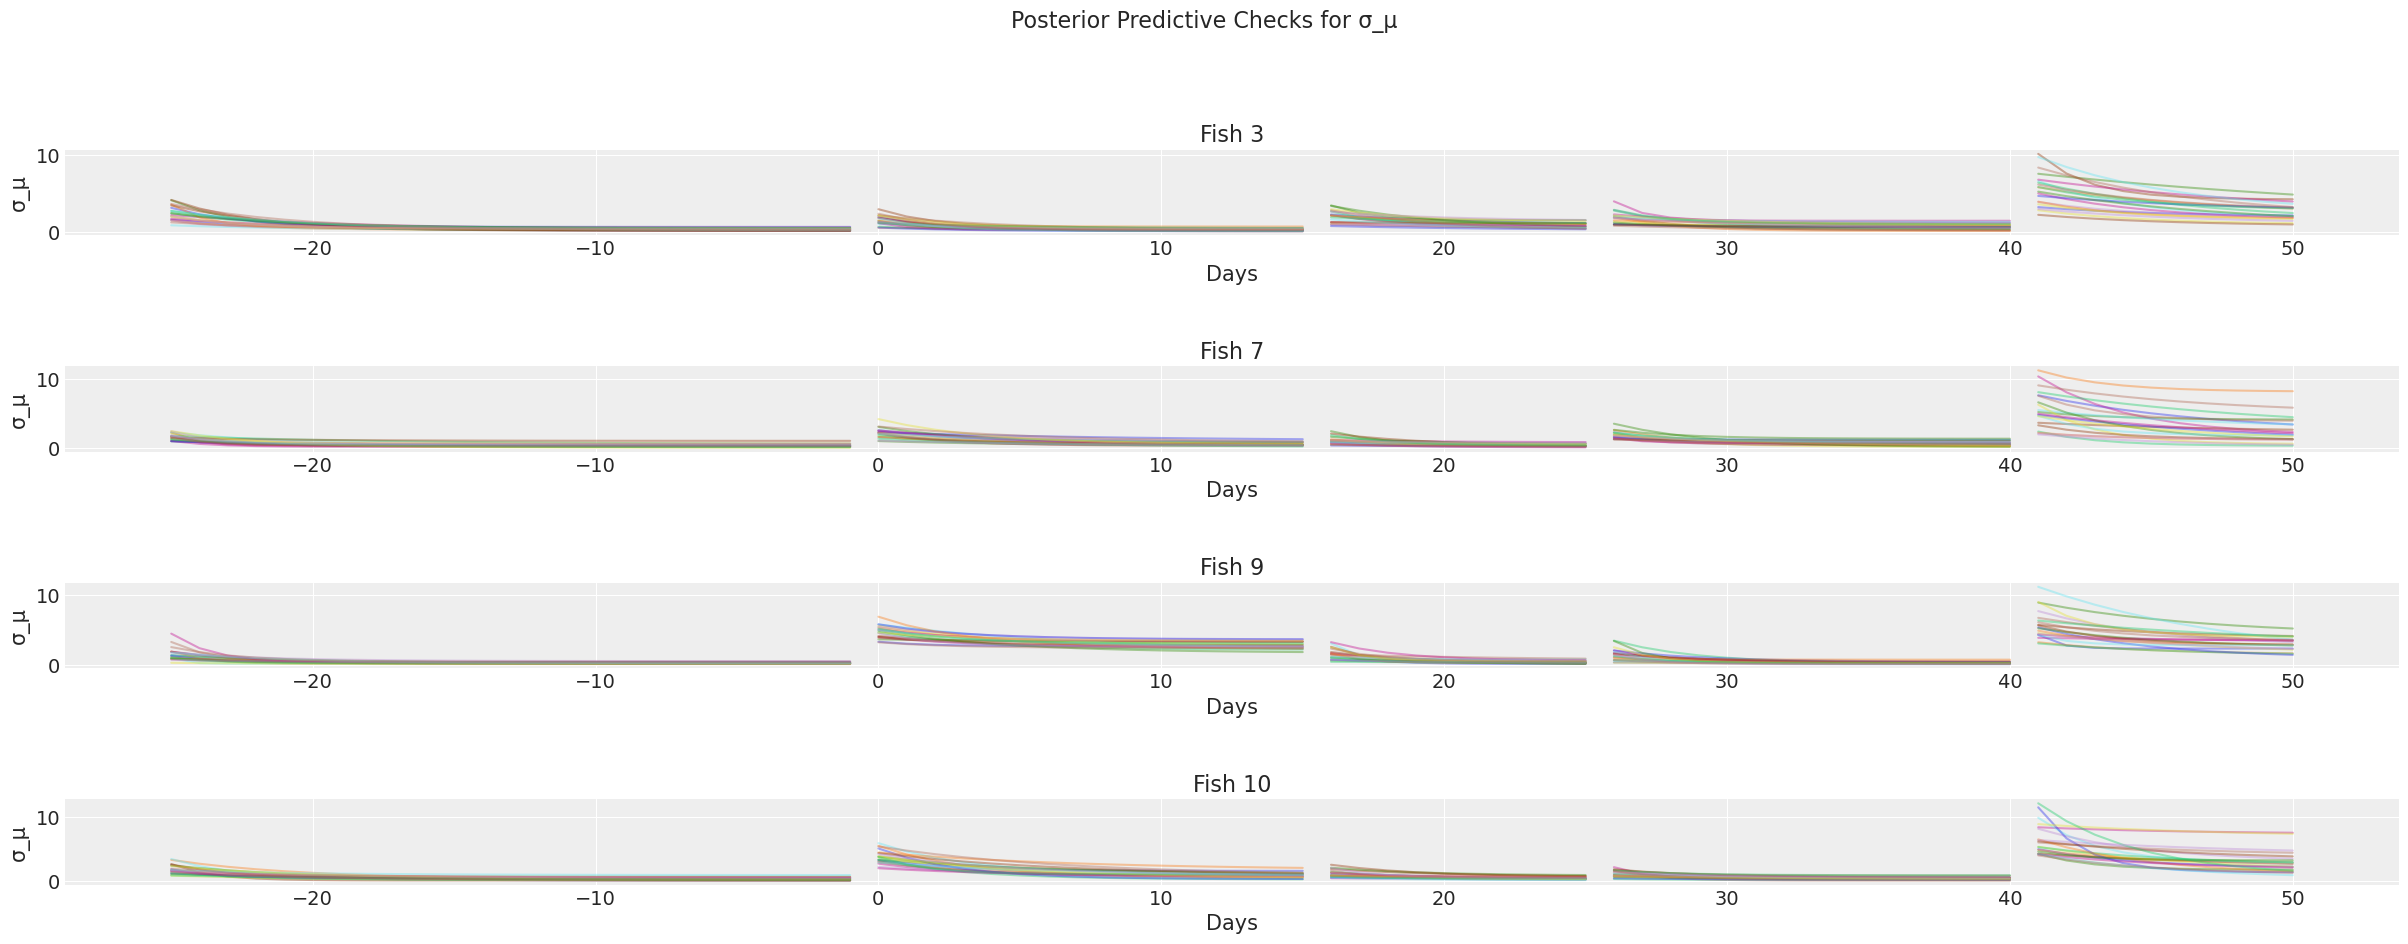

In [28]:
plot_hyperparameter_ppc_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [21]:
# def plot_Yds_across_BRWS_fish(data_dir, x_column='day', y_column='yds', hue_column='stage', palette='Set2'):
#     """
#     Create scatter plots for selected fish IDs in the given directory and save them to individual files.

#     Parameters:
#     - data_dir: Directory containing CSV files for each fish..
#     - output_dir: Directory where the plots will be saved.
#     - selected_fish_ids: List of fish IDs for which to create plots.
#     - x_column: Name of the column to be plotted on the x-axis (default: 'plotday').
#     - y_column: Name of the column to be plotted on the y-axis (default: 'average distance').
#     - y_column2: Name of the column to be plotted on the y-axis (default: 'distance').
#     - hue_column: Name of the column to determine the color of points (default: 'session_type').
#     - palette: Color palette for hue categories (default: 'Set2').
#     """
#     # Use Seaborn for better aesthetics
#     sns.set(style="whitegrid")
#     plt.style.use('default')
#     palette_colors = [ "orange",'red',"green",'blue']
#     # Iterate over each selected fish ID

# # Plot for each unique fish ID in the DataFrame
#     for fish_id in data_dir['fish'].unique():
#                 fish_df = data_dir[data_dir['fish'] == fish_id]

#                 plt.figure(figsize=(14, 4.8))
#                 sns.lineplot(x=x_column, y=y_column, hue=hue_column,data=fish_df, palette=palette_colors,alpha=0.3)

#                 #sns.scatterplot(x=x_column, y=y_column2, hue=hue_column, data=fish_df, palette=palette, alpha=0.5)
#                 plt.title(f'Yds Plot of {fish_id}')
#                 plt.xlabel('Session #', fontsize=24)
#                 plt.ylabel('Yds (m)', fontsize=24)
#                 #plt.legend().set_visible(False)
#                 plt.legend()
#                 plt.tight_layout()  # Adjust layout to make room for legend and labels
#                 plt.grid(False)  # Turn off the grid as specified
#                 # Get the current axes
#                 ax = plt.gca()
#                 # Remove the box outline
#                 ax.spines['top'].set_visible(False)
#                 ax.spines['right'].set_visible(False)

#                 plt.show()

In [23]:
# plot_Yds_across_BRWS_fish(df)

In [24]:

# # Define the data ranges for each fish
# fish_ranges = {
#     'Fish 3': (1, 359),
#     'Fish 7': (360, 616),
#     'Fish 9': (617, 1000),
#     'Fish 10': (1001, 1387)
# }

# # Plotting side-by-side
# fig, axes = plt.subplots(nrows=len(fish_ranges), ncols=1, figsize=(12, 8 * len(fish_ranges)))

# for i, (fish_name, (start_idx, end_idx)) in enumerate(fish_ranges.items()):
#     ax = axes[i]
    

    
#     num_draws_to_plot = 50
#     for draw_idx in range(num_draws_to_plot):
#         # Plot posterior predictive data for the current fish and draw
#         ax.plot(range(start_idx, end_idx + 1), ppc.y[1,draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - Posterior Predictive (Draw {draw_idx + 1})', color='blue',alpha=0.3)
#     # Plot observed data
#     ax.plot(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], label='Observed', color='red')
    
#     ax.set_xlabel('Trial')
#     ax.set_ylabel('Yds')
#     ax.set_title(fish_name)
#     #ax.legend()

# plt.tight_layout()
# plt.show()


In [25]:
# # Define the trial phase ranges for each fish
# fish_trial_phases = {
#     'Fish 3': {
#         'Baseline': (1, 155),
#         'Rotation': (156, 251),
#         'Washout': (252, 311),
#         'ReRotation': (312, 359)
#     },
#     'Fish 7': {
#         'Baseline': (360, 430),
#         'Rotation': (431, 520),
#         'Washout': (521, 580),
#         'ReRotation': (581, 616)
#     },
#     'Fish 9': {
#         'Baseline': (617, 757),
#         'Rotation': (758, 852),
#         'Washout': (853, 911),
#         'ReRotation': (912, 1000)
#     },
#     'Fish 10': {
#         'Baseline': (1001, 1149),
#         'Rotation': (1150, 1239),
#         'Washout': (1240, 1299),
#         'ReRotation': (1300, 1387)
#     }
# }

# # Plotting side-by-side for each fish and trial phase
# fig, axes = plt.subplots(nrows=len(fish_trial_phases), ncols=1, figsize=(12, 8 * len(fish_trial_phases)))

# for i, (fish_name, trial_phases) in enumerate(fish_trial_phases.items()):
#     ax = axes[i]
    
#     for phase_name, (start_idx, end_idx) in trial_phases.items():
#         # Plot observed data for the current trial phase
#         ax.plot(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], label=f'{fish_name} - {phase_name} (Observed)', color='red')
        
#         # Plot posterior predictive data for the current trial phase (using a single draw for simplicity)
#         draw_idx = 0  # Choose a specific draw index to plot (adjust as needed)
#         num_draws_to_plot = 1
#         for draw_idx in range(num_draws_to_plot):
#             ax.plot(range(start_idx, end_idx + 1), ppc.y[1,draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name}  Posterior Predictive (Draw {draw_idx + 1})', alpha=0.5)
    
#     ax.set_xlabel('Trial')
#     ax.set_ylabel('Yds')
#     ax.set_title(fish_name)
#     #ax.legend()

# plt.tight_layout()
# plt.show()

In [25]:


# # Define color mapping for trial phases
# phase_colors = {
#     'Baseline': 'yellow',
#     'Rotation': 'red',
#     'Washout': 'green',
#     'ReRotation': 'blue'
# }

# Define the trial phase ranges for each fish
fish_trial_phases = {
    'Fish 3': {
        'Baseline': (1, 155),
        'Rotation': (156, 251),
        'Washout': (252, 311),
        'ReRotation': (312, 359)
    },
    'Fish 7': {
        'Baseline': (360, 430),
        'Rotation': (431, 520),
        'Washout': (521, 580),
        'ReRotation': (581, 616)
    },
    'Fish 9': {
        'Baseline': (617, 757),
        'Rotation': (758, 852),
        'Washout': (853, 911),
        'ReRotation': (912, 1000)
    },
    'Fish 10': {
        'Baseline': (1001, 1149),
        'Rotation': (1150, 1239),
        'Washout': (1240, 1299),
        'ReRotation': (1300, 1387)
    }
}

# # Plotting side-by-side for each fish and trial phase
# fig, axes = plt.subplots(nrows=len(fish_trial_phases), ncols=1, figsize=(12, 8 * len(fish_trial_phases)))

# for i, (fish_name, trial_phases) in enumerate(fish_trial_phases.items()):
#     ax = axes[i]
    
#     for phase_name, (start_idx, end_idx) in trial_phases.items():
#         # Plot posterior predictive data for the current trial phase with the same color
#         draw_idx = 0  # Choose a specific draw index to plot (adjust as needed)
#         num_draws_to_plot = 100
#         for draw_idx in range(num_draws_to_plot):
#             ax.scatter(range(start_idx, end_idx + 1), ppc.y[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior Predictive (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.1)
            
#             ax.scatter(range(start_idx, end_idx + 1), posterior.μ_μ[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior μ_μ (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.5)
#             # Plot observed data for the current trial phase with specified color
#         #ax.plot(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#               #  label=f'{fish_name} - {phase_name} (Observed)', color=phase_colors[phase_name])
#         ax.scatter(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} (Observed)', color = 'black' )
        
#     ax.set_xlabel('Trial')
#     ax.set_ylabel('Yds')
#     ax.set_title(fish_name)
#     # ax.legend()

# plt.tight_layout()
# plt.show()


In [22]:
# Assuming 'posterior.μ_μ' is your xarray DataArray with dimensions [chain, draw, data]
# and that it has 1387 data points (or any other number, but for the sake of divisibility we assume a correct truncation)

# Ensure data points can be grouped into sets of 6
num_trials = posterior.μ_μ.shape[2]
num_days = num_trials // 6  # floor division to ignore any remainder trials that do not complete a day
trials_per_day = 6

# Truncate the last few trials if they don't make up a full day
truncated_data = posterior.μ_μ[:, :, :num_days * 6]

# Assign a new coordinate that groups every 6 trials into one day
truncated_data.coords['day'] = ('data', np.repeat(np.arange(num_days), trials_per_day))

# Group by the new 'day' coordinate and calculate the mean
daily_μ_μ = truncated_data.groupby('day').mean('data')

# daily_μ_μ now has dimensions [chain, draw, day] where 'day' represents the aggregated mean of every 6 trials


In [23]:
def get_fish_and_stage(day_index, fish_trial_phases, trials_per_day=6):
    # Convert day index to 1-based trial index
    trial_index = day_index * trials_per_day + 1
    
    # Iterate through each fish and their phases to find where the trial_index falls
    for fish, phases in fish_trial_phases.items():
        for stage, (start, end) in phases.items():
            if start <= trial_index <= end:
                return fish, stage
    
    return None, None  # Return None if no matching fish or stage is found


In [26]:
# Determine the number of days (based on the 'day' dimension)
num_days = daily_μ_μ.sizes['day']

# Create lists to hold the 'fish' and 'stage' labels for each day
fish_labels = []
stage_labels = []

# Loop over each day index to determine the corresponding fish and stage
for day_index in range(num_days):
    # Get the full fish name and stage name for the current day index
    fish, stage = get_fish_and_stage(day_index, fish_trial_phases)
    
    # Append the full fish and stage names to the labels lists
    fish_labels.append(fish)
    stage_labels.append(stage)

# Convert the lists to numpy arrays
fish_labels = np.array(fish_labels)
stage_labels = np.array(stage_labels)

# Add 'fish' and 'stage' as coordinates to the 'day' dimension
daily_μ_μ.coords['fish'] = ('day', fish_labels)
daily_μ_μ.coords['stage'] = ('day', stage_labels)

# Now 'daily_μ_μ' has additional coordinates 'fish' and 'stage' associated with each day

In [30]:
# # Plot posterior distribution with HDI
# pm.plot_posterior(posterior, hdi_prob=0.95, round_to=2)  # Adjust hdi_prob as needed (e.g., 0.95 for 95% HDI)
# plt.xlabel('Parameter of Interest')
# plt.title('Posterior Distribution with 95% HDI')

In [31]:
# # Plot posterior distribution with HDI
# pm.plot_posterior(posterior,var_names=['μ_μ'], hdi_prob=0.95, round_to=4)  # Adjust hdi_prob as needed (e.g., 0.95 for 95% HDI)
# plt.xlabel('Parameter of Interest')
# plt.title('Posterior Distribution with 95% HDI')

In [32]:
# az.plot_ppc(id_yds_numpyro, num_pp_samples=100);

In [33]:
# # Assuming `posterior` is your xarray.DataArray object containing posterior samples
# # Extract samples and flatten them
# samples = posterior.μ_μ.values.flatten()

# # Calculate quantiles and HDI
# quantile_3 = np.percentile(samples, 3)
# quantile_97 = np.percentile(samples, 97)
# hdi_3, hdi_97 = np.percentile(samples, [3, 97])

# # Calculate mean
# mean_value = np.mean(samples)

# # Plotting
# plt.figure(figsize=(8, 6))

# # Plot histogram of samples
# plt.hist(samples, bins=30, density=True, alpha=0.5, label='Posterior Samples')

# # Plot vertical lines for quantiles
# plt.axvline(quantile_3, color='red', linestyle='--', label='3rd Percentile')
# plt.axvline(quantile_97, color='green', linestyle='--', label='97th Percentile')

# # Plot shaded region for HDI
# plt.axvspan(hdi_3, hdi_97, color='blue', alpha=0.3, label='HDI (3-97%)')

# # Plot mean
# plt.axvline(mean_value, color='black', linestyle='-', linewidth=2, label='Mean')

# # Add labels, title, and legend
# plt.xlabel('Parameter of Interest')
# plt.ylabel('Density')
# plt.title('Posterior Distribution with HDI and Quantiles')
# plt.legend()

# # Show plot
# plt.show()

In [27]:
μ_μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94)  # Adjust hdi_prob as needed (e.g., 0.95 for 94% HDI)

In [28]:
y_ppc_plot = az.summary(ppc, var_names=['y'], hdi_prob=0.94)

In [29]:
y_obd_plot = obd.y.to_dataframe(name="y")

In [30]:
μ_plot = az.summary(posterior, var_names=['μ'], hdi_prob=0.94)


In [39]:

# Define fish_trial_phases dictionary
fish_trial_phases = {
    3: {
        'Baseline': (0, 155),
        'Rotation': (156, 251),
        'Washout': (252, 311),
        'ReRotation': (312, 359)
    },
    7: {
        'Baseline': (360, 430),
        'Rotation': (431, 520),
        'Washout': (521, 580),
        'ReRotation': (581, 616)
    },
    9: {
        'Baseline': (617, 757),
        'Rotation': (758, 852),
        'Washout': (853, 911),
        'ReRotation': (912, 1000)
    },
    10: {
        'Baseline': (1001, 1149),
        'Rotation': (1150, 1239),
        'Washout': (1240, 1299),
        'ReRotation': (1300, 1387)
    }
}

# Function to determine trial phase based on row index
def get_trial_phase(index):
    for fish, phases in fish_trial_phases.items():
        for phase, (start, end) in phases.items():
            if start <= index <= end:
                return fish, phase, index - start + 1
    # Return default values (e.g., NaN) if no trial phase is found
    return None, None, None

# Apply function to create new columns 'fish', 'stage', 'day'
y_obd_plot['index'] = y_obd_plot.index  # Create a new column 'index' to work with the index
y_obd_plot['fish'], y_obd_plot['stage'], y_obd_plot['day'] = zip(*y_obd_plot['index'].map(get_trial_phase))

# Drop the 'index' column (optional)
y_obd_plot.drop(columns=['index'], inplace=True)
# Map day values such that each 6-day cycle is treated as 1 day
y_obd_plot['day'] = np.ceil(y_obd_plot['day'] / 6).astype(int)


In [111]:

y_obd_plot['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
y_obd_plot['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

# Initialize plotday column with NaN
y_obd_plot['plotday'] = None

# Iterate through each row to calculate plotday based on 'fish' and 'day'
current_fish = None
current_day = None
current_plotday = 0

for index, row in y_obd_plot.iterrows():
    if row['fish'] != current_fish:
        # New fish encountered, reset plotday to 1
        current_fish = row['fish']
        current_day = row['day']
        current_plotday = 1
    elif row['day'] != current_day:
        # Same fish but different day, increment plotday
        current_day = row['day']
        current_plotday += 1
    
    # Update plotday for the current row
    y_obd_plot.at[index, 'plotday'] = current_plotday

# Convert plotday column to numeric
y_obd_plot['plotday'] = pd.to_numeric(y_obd_plot['plotday'], errors='coerce')





In [112]:
y_obd_plot

y  fish       stage  day  plotday
data                                          
0    -0.593089     3    Baseline    1        1
1     3.303538     3    Baseline    1        1
2     1.553468     3    Baseline    1        1
3     2.407542     3    Baseline    1        1
4     0.098092     3    Baseline    1        1
...        ...   ...         ...  ...      ...
1382  0.123611    10  ReRotation   14       64
1383  0.199964    10  ReRotation   14       64
1384  0.111023    10  ReRotation   15       65
1385  4.275042    10  ReRotation   15       65
1386  2.917670    10  ReRotation   15       65

[1387 rows x 5 columns]

In [33]:
# Rename columns in each DataFrame
μ_μ_plot_renamed = μ_μ_plot.rename(columns={'mean': 'μ_μ_y', 'hdi_3%': 'μ_μ_hdi_3%','hdi_97%': 'μ_μ_hdi_97%'})
μ_plot_renamed = μ_plot.rename(columns={'mean': 'μ_y', 'hdi_3%': 'μ_hdi_3%','hdi_97%': 'μ_hdi_97%'})
y_ppc_plot_renamed = y_ppc_plot.rename(columns={'mean': 'ppc_y', 'hdi_3%': 'ppc_hdi_3%','hdi_97%': 'ppc_hdi_97%'})

In [34]:
μ_μ_plot_renamed = μ_μ_plot_renamed.reset_index(drop=True) 
μ_plot_renamed = μ_plot_renamed.reset_index(drop=True) 
y_ppc_plot_renamed = y_ppc_plot_renamed.reset_index(drop=True) 

In [42]:
ppcplot_df = pd.concat([y_obd_plot, μ_μ_plot_renamed[['μ_μ_y','μ_μ_hdi_3%','μ_μ_hdi_97%']],μ_plot_renamed[['μ_y','μ_hdi_3%','μ_hdi_97%']], y_ppc_plot_renamed[['ppc_y','ppc_hdi_3%','ppc_hdi_97%']]], axis=1)

In [56]:
# Define a list of stages in the correct order
stages = ['Baseline', 'Rotation', 'Washout', 'ReRotation']


# Define color mapping for trial phases
phase_colors = {
    'Baseline': 'yellow',
    'Rotation': 'red',
    'Washout': 'green',
    'ReRotation': 'blue'
}
# Convert 'stage' column to categorical type with specified order
ppcplot_df['stage'] = pd.Categorical(ppcplot_df['stage'], categories=stages, ordered=True)

# Group by 'fish', 'stage', and 'day' columns, calculate mean of 'y' for each group
ppcplot_df_day = ppcplot_df.groupby(['fish','stage', 'day']).agg(
    mean_y =('y', 'mean'),
    mean_μ_μ_y =('μ_μ_y', 'mean'),
    mean_μ_μ_hdi_3 =('μ_μ_hdi_3%', 'mean'),
    mean_μ_μ_hdi_97 =('μ_μ_hdi_97%', 'mean'),
    mean_μ_y =('μ_y', 'mean'),
    mean_μ_hdi_3 =('μ_hdi_3%', 'mean'),
    mean_μ_hdi_97 =('μ_hdi_97%', 'mean'),
    mean_ppc_y =('ppc_y', 'mean'),
    mean_ppc_hdi_3 =('ppc_hdi_3%', 'mean'),
    mean_ppc_hdi_97 =('ppc_hdi_97%', 'mean')
).reset_index()

# Define conditions to set 'plotday' to NaN where 'mean_y' is NaN
condition = pd.isna(ppcplot_df_day['mean_y'])

# Set 'plotday' to NaN where 'mean_y' is NaN
ppcplot_df_day.loc[condition, 'plotday'] = None

# Calculate 'plotday' based on change in 'day' within the same 'fish' group where 'mean_y' is not NaN
ppcplot_df_day.loc[~condition, 'plotday'] = (
    ppcplot_df_day.loc[~condition].groupby('fish').cumcount()
    + (ppcplot_df_day.loc[~condition, 'day'] != ppcplot_df_day.loc[~condition, 'day'].shift()).astype(int)
)
ppcplot_df_day = ppcplot_df_day[pd.notna(ppcplot_df_day['mean_y'])]
ppcplot_df_day['plotday'] = pd.to_numeric(ppcplot_df_day['plotday'], errors='coerce')



C:\Users\86153\AppData\Local\Temp\ipykernel_7212\1817068773.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppcplot_df_day = ppcplot_df.groupby(['fish','stage', 'day']).agg(


In [58]:

# Save the DataFrame to CSV file
ppcplot_df_day.to_csv('ppcplot.csv', index=False)

In [43]:
# # Iterate over each unique combination of fish and stage to create plots
# for fish in ppcplot_df_day['fish'].unique():
#     plt.figure(figsize=(14, 4.8))  # Set figure size
    
#     for i, stage in enumerate(stages):
# # Filter data for the current fish and stage
#         data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        
#         # Plot mean_y against plotday for the current stage
#         plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color=phase_colors[stage])
#                  # Plot mean_y against plotday for the current stage
#         plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
#         plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
           
#          # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
#        # plt.fill_between(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'], data_filter['mean_μ_μ_hdi_97'],color=phase_colors[stage], alpha=0.3, label=f'HDI - {stage}')
#         plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
#         plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

#             # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
#         #plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
#         #                     color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
    
#     plt.xlabel('Plot Day')  # Set x-axis label
#     plt.ylabel('Mean Y')   # Set y-axis label
#     plt.title(f'Fish {fish} - Mean Yds by Stage')  # Set plot title
#    # plt.legend()  # Show legend
#     plt.ylim((-10,10))
#     plt.grid(True)  # Show grid
#     plt.show()  # Display the plot


In [115]:
y_obd_plot.to_csv('y_obdplot.csv', index=False)

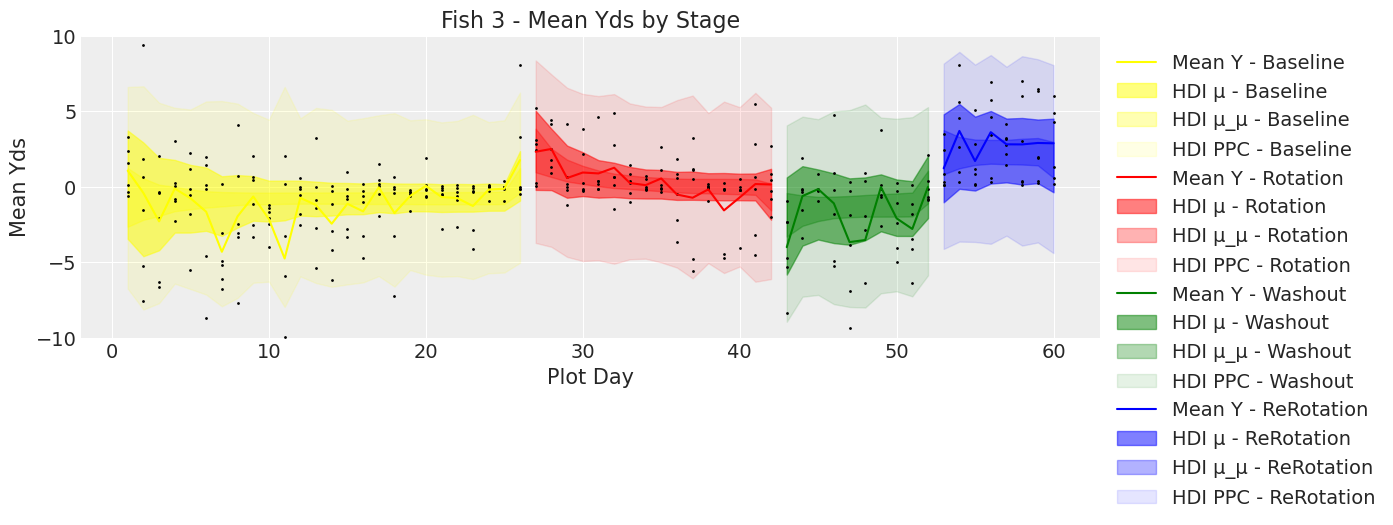

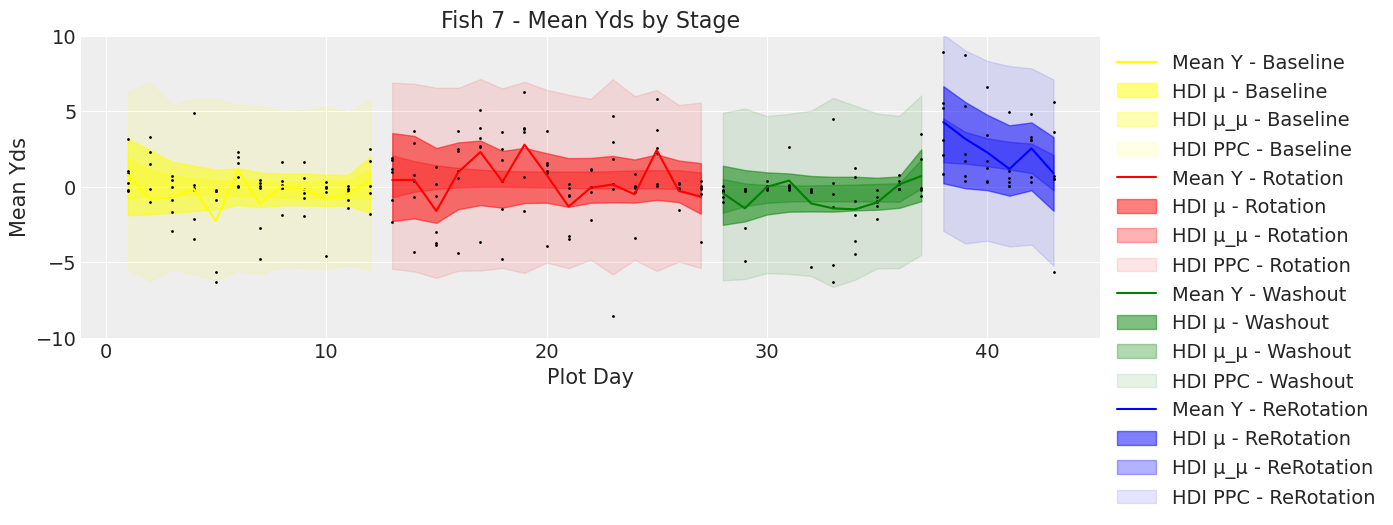

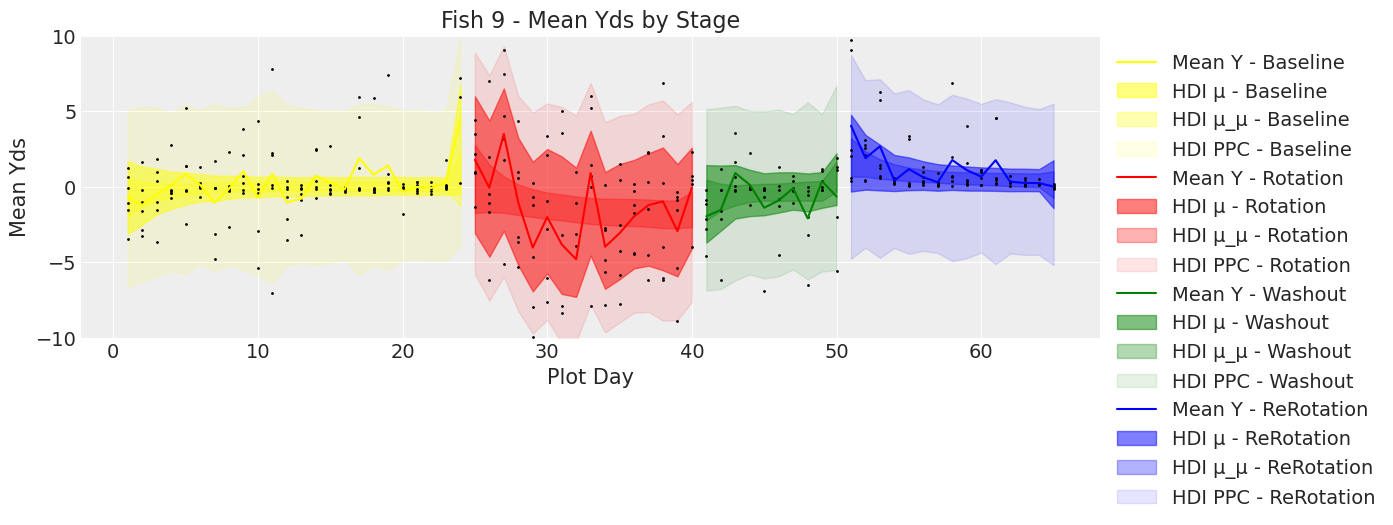

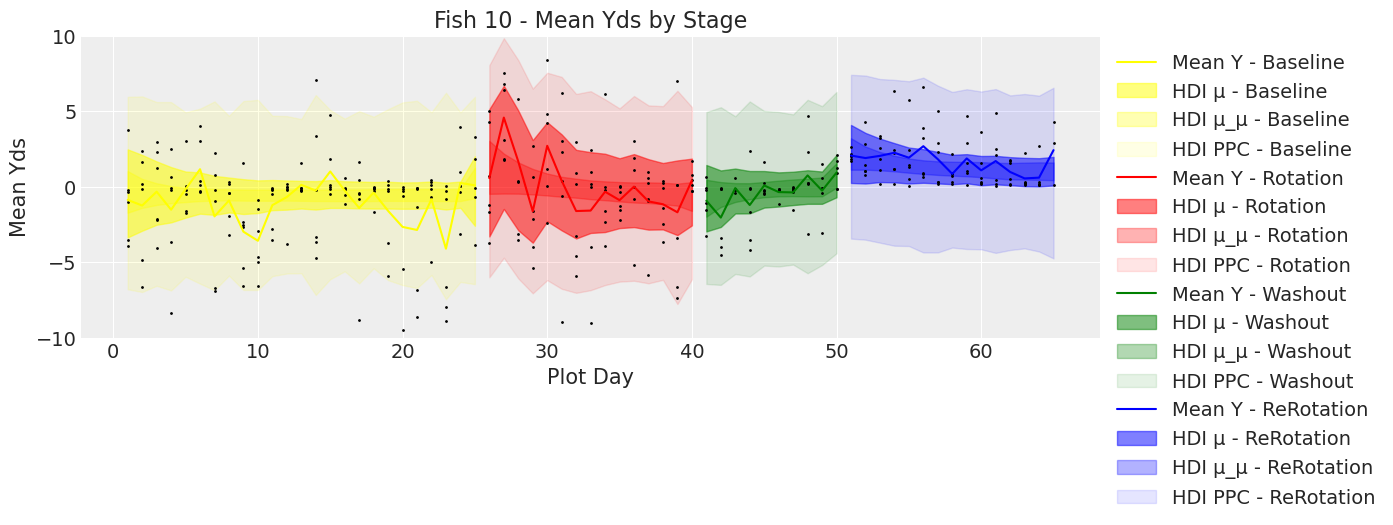

In [121]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(14, 4.8))  # Set figure size
    
    for i, stage in enumerate(stages):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
        # Plot mean_y against plotday for the current stage
        plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color=phase_colors[stage])
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        
        plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'], data_filter['mean_μ_μ_hdi_97'],color=phase_colors[stage], alpha=0.3, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
                            color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color= 'black',s =1)
    
    plt.xlabel('Plot Day')  # Set x-axis label
    plt.ylabel('Mean Yds')   # Set y-axis label
    plt.title(f'Fish {fish} - Mean Yds by Stage')  # Set plot title
    plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((-10,10))
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot
